<font size=6>Automatic tagging of questions  
Part 2 : Unsupervised approach - Topic modeling</font>

---

**Checking environment**

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules
# PATH_DRIVE : to change according to your Google Drive folders
PATH_DRIVE = "/content/drive/My Drive/MachineLearning/ML05"

In [ ]:
if IN_COLAB:
    print("Le notebook est exécuté sur Google Colab")
else:
    print("Le notebook est exécuté en local")

Le notebook est exécuté sur Google Colab


In [ ]:
if IN_COLAB:
    from google.colab import drive, files
    drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

<font size=5>**Table of contents**</font>

[1. Notebook preparation](#1_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1. Custom classes and methods](#1_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.2. Data loading](#1_2)  
  
[2. Topic modeling with Latent Dirichlet Allocation (LDA)](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1. Impact of vectorization options on LDA coherence score](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2. Impact of the number of topics and the min_df parameter on the coherence score](#2_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3. Topic modeling analysis - 4 topics and a min-df of 6%](#2_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4. Topic modeling analysis - 5 topics and a min-df of 5%](#2_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5. Topic modeling analysis - 6 topics and a min-df of 7%](#2_5)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6. pyLDAvis visualization - 6 topics and a min-df of 7%](#2_6)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7. TSNE visualization - 6 topics and a min-df of 7%](#2_7)  
  
[3. LDA - Optimisation of hyperparameters with hyperopt](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1. Running Hyperopt](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2. Results analysis](#3_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3. Second optimization run](#3_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4. Optimal LDA model analysis](#3_4)  
  
[4. Topic modeling with Non-negative Matrix Factorization (NMF)](#4_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1. Impact of vectorization options on NMF coherence score](#4_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2. Impact of the number of topics and the min-df parameter on the coherence score](#4_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.3. Alternative try : using Universal Sentence Encoder together with NMF](#4_3)  
  
[5. Annex for part 3 of the project : Calculation of coherence score of the best semi-supervised model](#5_0)  

---
## <font color=blue>Notebook set-up</font>

**Libraries importation**

In [ ]:
if IN_COLAB:
    !pip install -U tmtoolkit

Requirement already up-to-date: tmtoolkit in /usr/local/lib/python3.6/dist-packages (0.10.0)


In [ ]:
if IN_COLAB:
    !pip install scikit-multilearn

In [ ]:
if IN_COLAB:
    !pip install pyldavis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import csv
import tensorflow_hub as hub
if IN_COLAB:
  nltk.download('stopwords')
  nltk.download('wordnet')
  nltk.download('punkt')
  import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from skmultilearn.model_selection import iterative_train_test_split
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
from wordcloud import WordCloud
from hyperopt import hp, STATUS_OK, tpe, fmin, Trials, space_eval
from timeit import default_timer as timer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
if IN_COLAB:
    sys.path.append(PATH_DRIVE)
    os.chdir(PATH_DRIVE)
    import sf_graphiques as sfg
else:
    import modules_perso.sf_graphiques as sfg

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Notebook set-up**

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = fig_id + "." + fig_extension
    if IN_COLAB:
        path = PATH_DRIVE + "/" + path
    #print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution)

---
<a id='1_0'></a>

## <font color=blue>1. Notebook preparation</font>

### 1.1. Custom classes and methods

In [ ]:
class TextFactorization(BaseEstimator):

    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model
        self.doctexts = None
        self.matrix_docwords = None
        self.matrix_doctopics = None
        self.matrix_topicswords = None

    def fit(self, X, y=None):
        self.matrix_docwords = self.vectorizer.fit_transform(X)
        tokenizer = self.vectorizer.build_analyzer()
        self.doctexts = [tokenizer(lin) for idx, lin in X.items()]
        self.matrix_doctopics = self.model.fit_transform(self.matrix_docwords)
        self.matrix_topicswords = self.model.components_
        return self

    def transform(self, X=None):
        if X is None:
            return self.matrix_doctopics
        dtm = self.vectorizer.transform(X)
        return self.model.transform(dtm)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.matrix_doctopics

    def coherence_score(self, measure="c_v", n_top_words=20):
        cs = metric_coherence_gensim(
            measure=measure,
            top_n=n_top_words,
            topic_word_distrib=self.matrix_topicswords,
            dtm=self.matrix_docwords,
            vocab=np.array(self.vectorizer.get_feature_names()),
            texts=self.doctexts,
            return_mean=True)
        return cs

    def print_topics(self, n_top_words=20):
        vocab = self.vectorizer.get_feature_names()
        for topic_idx, topic in enumerate(self.model.components_):
            print("\nTopic {}:".format(topic_idx))
            print(" ".join([vocab[i]
                            for i in topic.argsort()[:-n_top_words-1:-1]]))
    
    def show_wordcloud(self, idx_topic):
        freq = dict()
        for word, coef in zip(self.vectorizer.get_feature_names(), self.model.components_[idx_topic]):
            freq[word] = coef
        graph = sfg.MyGraph("Words of topic n°{}".format(idx_topic), y_title=0.90)
        fig, ax = graph.fig, graph.ax
        wc = WordCloud(relative_scaling=0.33,
                       background_color="whitesmoke",
                       contour_color="lightgrey")\
             .generate_from_frequencies(freq)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

In [ ]:
def get_fact_results(filename):
    df = pd.read_csv(filename)
    df["bow_ngrams"] = [param[param.find("vectorizer__ngram_range")+26: -1]
                        for param in df.params]
    df["bow_mindf"] = [np.around(
        np.float(param[param.find("vectorizer__min_df")+21:
                       param.find("vectorizer__ngram_range")-3]), 3)
        for param in df.params]
    df["bow_maxdf"] = [np.around(
        np.float(param[param.find("vectorizer__max_df")+21:
                       param.find("vectorizer__min_df")-3]), 3)
        for param in df.params]
    df["lda_ntopics"] = [np.int(param[param.find("model__n_components")+22: 
                                      param.find("model__topic_word_prior")-3])
                         for param in df.params]
    df["lda_alpha"] = [np.float(param[param.find("model__doc_topic_prior")+25:
                             param.find("model__n_components")-3])
                       for param in df.params]
    df["lda_beta"] = [np.float(param[param.find("model__topic_word_prior")+26:
                            param.find("vectorizer__max_df")-3])
                      for param in df.params]
    return df.drop(columns="params")

In [ ]:
def graph_discret_coherencescore(df, column_analysis, title_analysis,
                                 tick_step=1, rotation=0,
                                 ymin=0, ymax=1, show_time=False):
    values = []
    labels = []
    for cl in np.unique(df[column_analysis]):
        if show_time:
            values.append(df[df[column_analysis]==cl].factorization_time.max())
            subtitle = "Processing Time"
        else:
            values.append(df[df[column_analysis]==cl].loss.max())
            subtitle = "Coherence Score"
        labels.append(cl)
    graph = sfg.MyGraph("LDA optimization : {} analysis"\
                        .format(title_analysis))
    graph.add_barv(np.arange(len(labels)), values, subtitle=subtitle)
    graph.ax[0].set_xticks(np.arange(0, len(labels), tick_step))
    graph.set_axe_x(label=title_analysis,
                    tick_labels=labels[::tick_step],
                    rotation=rotation, tick_dash=True)
    if show_time:
        graph.set_axe_y(label="Maximum time (seconds)")
    else:
        graph.set_axe_y(label="Maximum coherence score c_v",
                        tick_min=ymin, tick_max=ymax)
    if not show_time:
        ymin, ymax = graph.ax[0].get_ylim()
        idx_max = np.argmax(values)
        graph.add_fleches(idx_max, ymax, 0, values[idx_max]-ymax,
                          units='xy', color="dimgrey")
    return graph.fig, graph.ax

In [ ]:
def graph_continu_coherencescore(df, column_analysis, title_analysis,
                                 nb_steps=10, rotation=0, xticks_format=":.3f",
                                 ymin=0, ymax=1, alpha=0.8,
                                 show_time=False, preview=False):
    graph = sfg.MyGraph("LDA optimization : {} analysis"\
                        .format(title_analysis))
    if preview:
        if show_time:
            values = df.factorization_time
            subtitle = "Processing Time"
        else:
            values = df.loss
            subtitle = "Coherence Score"
        labels = df[column_analysis]
        graph.add_plot(labels, values, marker='o', linestyle='',
                       with_grid='both', grid_style=':', subtitle=subtitle)
    else:
        values = []
        labels = []
        for cl in np.unique(df[column_analysis]):
            if show_time:
                values.append(df[df[column_analysis]==cl]\
                              .factorization_time.max())
                subtitle = "Processing Time"
            else:
                values.append(df[df[column_analysis]==cl].loss.max())
                subtitle = "Coherence Score"
            labels.append(cl)
        graph.add_area(labels, values, ymin, alpha=alpha,
                      with_grid='both', grid_style=':', subtitle=subtitle)
    tickmin, tickmax = graph.ax[0].get_xlim()
    tickstep = (tickmax - tickmin) / nb_steps
    graph.set_axe_x(label=title_analysis,
                    tick_min=tickmin, tick_max=tickmax, tick_step=tickstep,
                    tick_labels_format=xticks_format,
                    rotation=rotation)
    if show_time:
        graph.set_axe_y(label="Maximum time (seconds)")
    else:
        graph.set_axe_y(label="Maximum coherence score c_v",
                        tick_min=ymin, tick_max=ymax)
    if not show_time:
        ymin, ymax = graph.ax[0].get_ylim()
        idx_max = np.argmax(values)
        graph.add_fleches(labels[idx_max], ymax, 0, values[idx_max]-ymax,
                          units='xy', color="dimgrey")
    return graph.fig, graph.ax

In [ ]:
def graph_cross_coherencescore(df, columnx, columny, namex, namey,
                               cmap ='RdYlGn', vmin=None, rotation=0,
                               xmin=None, xmax=None, xstep=None, xlog=False,
                               ymin=None, ymax=None, ystep=None, ylog=False):
    if vmin is None:
        vmin = np.NINF
    xlabels = []
    ylabels = []
    values = []
    for attx in np.unique(df[columnx]):
        for atty in np.unique(df[df[columnx]==attx][columny]):
            max_score = df[(df[columnx]==attx) & (df[columny]==atty)].loss.max()
            if max_score > vmin:
                values.append(max_score)
                xlabels.append(attx)
                ylabels.append(atty)
    graph = sfg.MyGraph("LDA optimization : {} vs {} analysis"\
                        .format(namex, namey))
    graph.add_scatter(xlabels, ylabels, color=values, cmap=cmap)
    graph.set_axe_x(label=namex, tick_min=xmin, tick_max=xmax,
                    tick_step=xstep, rotation=rotation)
    if xlog:
        graph.ax[0].set_xscale('log')
    graph.set_axe_y(label=namey, tick_min=ymin, tick_max=ymax,
                    tick_step=ystep)
    if ylog:
        graph.ax[0].set_yscale('log')
    scat = graph.objets[0]
    cb = graph.fig.colorbar(scat)
    cb.set_label("Coherence score")
    return graph.fig, graph.ax

<a id="1_2"></a>

### 1.2. Data loading

In [ ]:
X_fulltrain = pd.read_csv("X_train.csv", index_col=0, lineterminator='\n')
y_fulltrain = pd.read_csv("y_train.csv", index_col=0)
X_train = pd.read_csv("X_subtrain.csv", index_col=0, lineterminator='\n')
y_train = pd.read_csv("y_subtrain.csv", index_col=0)
X_valid = pd.read_csv("X_subvalid.csv", index_col=0, lineterminator='\n')
y_valid = pd.read_csv("y_subvalid.csv", index_col=0)
X_mini = pd.read_csv("X_mini.csv", index_col=0, lineterminator='\n')
y_mini = pd.read_csv("y_mini.csv", index_col=0)

I add a column named "both" to the dataframe X_mini to aggregate the body and the title.

In [ ]:
X_mini["both"] = X_mini["title"].fillna(" ") + " " + X_mini["body"].fillna(" ")

I create a Pipeline to be able to easily test several options :
- the use of words, bigrams and trigrams.
- the use of a bag of words, a TF-IDF matrix or word embedding.
  
I use the same stopwords (union of sklearn and nltk stopwords) and the same regex for token_pattern that I used in the data exploration. To limit the number of analysed words, I put min_df at 1%.

In [ ]:
full_stop_words = nltk.corpus.stopwords.words("english") + list(set(stop_words.ENGLISH_STOP_WORDS) - set(nltk.corpus.stopwords.words("english")))
my_regex = "(?!\d+)\w+[\w\+\#]*"
my_mindf = 0.01

<input>:2: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \d
<ipython-input-14-2f147d95ba6d>:2: DeprecationWarning: invalid escape sequence \d
  my_regex = "(?!\d+)\w+[\w\+\#]*"


---
<a id='2_0'></a>

## <font color=blue>2. Topic modeling with Latent Dirichlet Allocation (LDA)</font>

### 2.1. Impact of vectorization options on LDA coherence score

I want to study :
- the interest to use TF-IDF instead of Bag of words ;
- the interest to use bigrams and trigrams in addition to single words ;
- the interest to base the analysis on the body, on the title or on the aggregation of both.

I start by defining an arbitrary number of 10 topics.  
I look at a base coherence score c_v with a bag of words, monograms and the body as input.  
Then I change only one of those components to check if I can get a substantial increase in the coherence score with an alternative strategy.

In [ ]:
bow = CountVectorizer(token_pattern=my_regex,
                      stop_words=full_stop_words,
                      ngram_range=(1, 1),
                      min_df=my_mindf)
tfidf = TfidfVectorizer(token_pattern=my_regex,
                        stop_words=full_stop_words,
                        ngram_range=(1, 1),
                        min_df=my_mindf)

In [ ]:
lda = LatentDirichletAllocation(n_components=10, 
                                n_jobs=-1,
                                random_state=42)
nmf = NMF(n_components=10,
          random_state=42)

In [ ]:
fact = TextFactorization(vectorizer=bow, model=lda)
fact.fit(X_mini.body)
base_score = fact.coherence_score()
print(base_score)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


0.4213031416600169


In [ ]:
fact = TextFactorization(vectorizer=tfidf, model=lda)
fact.fit(X_mini.body)
tfidf_score = fact.coherence_score()
print(tfidf_score)

0.43950369046532545


In [ ]:
bow.set_params(**{"ngram_range": (1, 2)})
fact = TextFactorization(vectorizer=bow, model=lda)
fact.fit(X_mini.body)
bigrams_score = fact.coherence_score()
print(bigrams_score)

0.5890826056737606


In [ ]:
bow.set_params(**{"ngram_range": (1, 3)})
fact = TextFactorization(vectorizer=bow, model=lda)
fact.fit(X_mini.body)
trigrams_score = fact.coherence_score()
print(trigrams_score)

0.7301358177206054


In [ ]:
bow.set_params(**{"ngram_range": (1, 1)})
fact = TextFactorization(vectorizer=bow, model=lda)
fact.fit(X_mini.title)
title_score = fact.coherence_score()
print(title_score)

0.31305286470617694


In [ ]:
fact = TextFactorization(vectorizer=bow, model=lda)
fact.fit(X_mini.both)
both_score = fact.coherence_score()
print(both_score)

0.3870196268384998


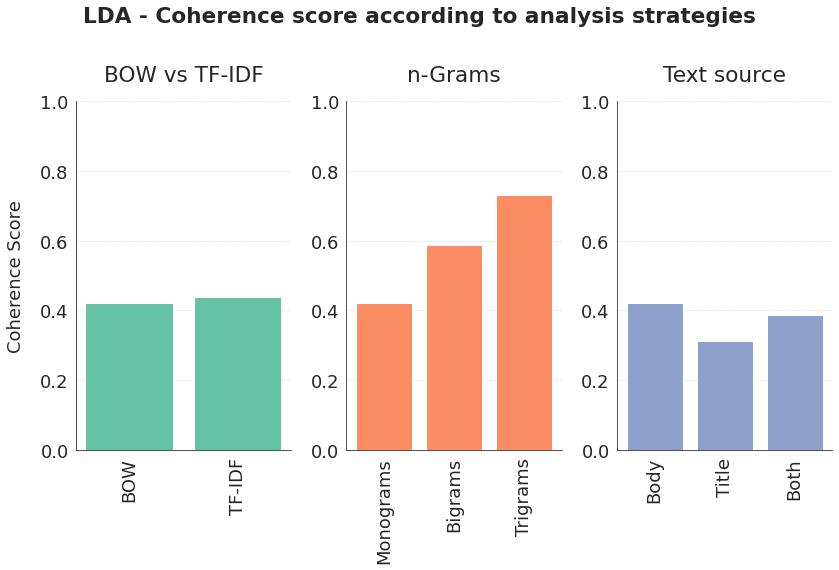

In [ ]:
graph = sfg.MyGraph("LDA - Coherence score according to analysis strategies",
                    y_title=1.0, nblin=1, nbcol=3)
graph.add_barv(["BOW", "TF-IDF"],
               [base_score, tfidf_score],
               subtitle="BOW vs TF-IDF", multi_index=1)
graph.add_barv(["Monograms", "Bigrams", "Trigrams"],
               [base_score, bigrams_score, trigrams_score],
               subtitle="n-Grams", color=graph.liste_couleurs[1],
               multi_index=2)
graph.add_barv(["Body", "Title", "Both"],
               [base_score, title_score, both_score],
               subtitle="Text source", color=graph.liste_couleurs[2],
               multi_index=3)
graph.set_axe_y(label="Coherence Score", tick_min=0, tick_max=1,
                multi_index=1)
graph.set_axe_y(tick_min=0, tick_max=1, multi_index=2)
graph.set_axe_y(tick_min=0, tick_max=1, multi_index=3)
graph.set_axe_x(rotation=90, multi_index=1)
graph.set_axe_x(rotation=90, multi_index=2)
graph.set_axe_x(rotation=90, multi_index=3)
fig, ax = graph.fig, graph.ax
save_fig("ml05_02_first_observations")
plt.show()

In theory, LDA is a probabilistic model that should be based on a bag of words, because TF-IDF change the distribution of the words across the documents.  
Our results don't fully match the theory : Bag of Words and TF-IDF get a very close coherence score, with a small advantage to TF-IDF. I will stick with the theory and use Bag of Words for the rest of LDA study.

Best coherence score is obtained by using the text of the body, rather than the text of title or both texts. This was not intuitive with our observations during the exploration.

The real improvement in coherence score is achieved by adding bigrams and trigrams to monograms.  
Now, I can study :
- the optimal number of topics ;  
- the optimal mindf parameter ;  

based on a Bag of Words of monograms + bigrams + trigrams of the body text.

<a id="2_2"></a>

### 2.2. Impact of the number of topics and the min_df parameter on the coherence score

In [ ]:
coherence_scores = pd.DataFrame(columns=["n_components",
                                         "min_df",
                                         "coherence_score"])

In [ ]:
bow.set_params(**{"ngram_range": (1, 3)})
idx = 0
for ncompo in range(2, 21):
    lda.set_params(**{"n_components": ncompo})
    for mindf in [0.05, 0.025, 0.01, 0.005]:
        bow.set_params(**{"min_df": mindf})
        fact = TextFactorization(vectorizer=bow, model=lda)
        fact.fit(X_mini.body)
        cs = fact.coherence_score()
        coherence_scores.loc[idx] = [ncompo, mindf, cs]
        idx += 1

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [ ]:
coherence_scores

n_components  min_df  coherence_score
0            2.0   0.050         0.753469
1            2.0   0.025         0.770983
2            2.0   0.010         0.770209
3            2.0   0.005         0.769201
4            3.0   0.050         0.760670
..           ...     ...              ...
71          19.0   0.005         0.697964
72          20.0   0.050         0.757611
73          20.0   0.025         0.743526
74          20.0   0.010         0.708178
75          20.0   0.005         0.694028

[76 rows x 3 columns]

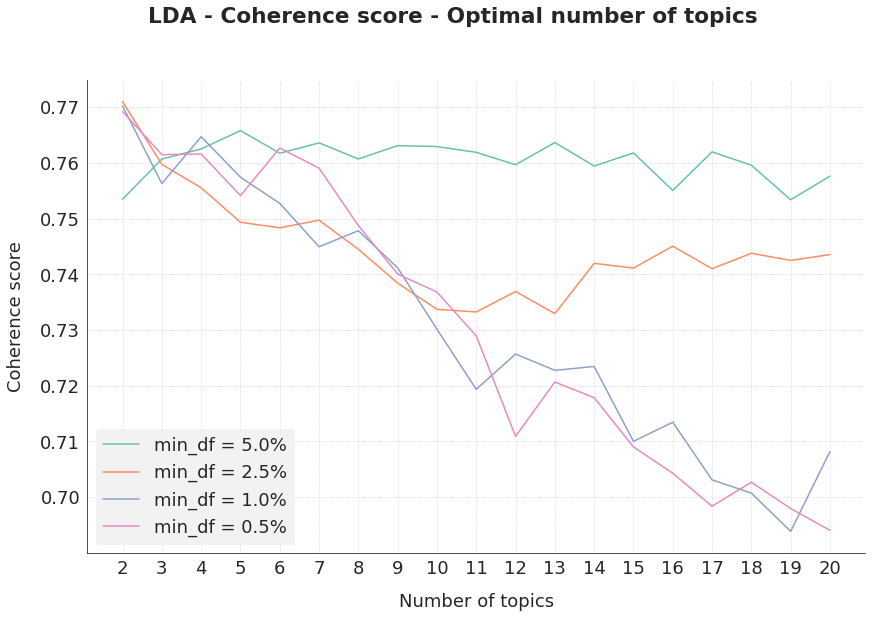

In [ ]:
graph = sfg.MyGraph("LDA - Coherence score - Optimal number of topics")
for mindf in coherence_scores.min_df.unique():
    graphdata = coherence_scores[coherence_scores.min_df == mindf]
    graph.add_plot(graphdata.n_components,
                   graphdata.coherence_score,
                   label="min_df = {:.1%}".format(mindf),
                   with_grid="both", grid_style=":", legend=True)
graph.set_axe_x(label="Number of topics", tick_labels_format=":.0f",
                tick_min=2, tick_max=20, tick_step=1)
graph.set_axe_y(label="Coherence score")
fig, ax = graph.fig, graph.ax
plt.show()

Best scores are obtained with a min_df set to 5%, at almost everey number of components.
I should try min_df from 4% to 7% to see if those settings lead to a better coherence score. I don't go over 7% to keep enough words in the bag of words.

In [ ]:
coherence_scores2 = pd.DataFrame(columns=["n_components",
                                         "min_df",
                                         "coherence_score"])

In [ ]:
idx = 0
bow.set_params(**{"ngram_range": (1, 3)})
for ncompo in range(2, 21):
    lda.set_params(**{"n_components": ncompo})
    for mindf in [0.04, 0.05, 0.06, 0.07]:
        bow.set_params(**{"min_df": mindf})
        fact = TextFactorization(vectorizer=bow, model=lda)
        fact.fit(X_mini.body)
        cs = fact.coherence_score()
        coherence_scores2.loc[idx] = [ncompo, mindf, cs]
        idx += 1

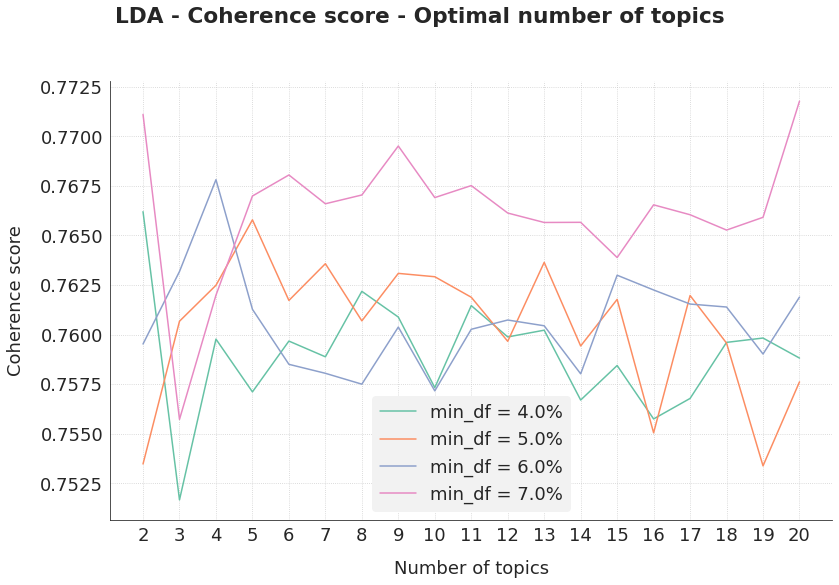

In [ ]:
graph = sfg.MyGraph("LDA - Coherence score - Optimal number of topics")
for mindf in coherence_scores2.min_df.unique():
    graphdata = coherence_scores2[coherence_scores2.min_df == mindf]
    graph.add_plot(graphdata.n_components,
                   graphdata.coherence_score,
                   label="min_df = {:.1%}".format(mindf),
                   with_grid="both", grid_style=":", legend=True)
graph.set_axe_x(label="Number of topics", tick_labels_format=":.0f",
                tick_min=2, tick_max=20, tick_step=1)
graph.set_axe_y(label="Coherence score")
fig, ax = graph.fig, graph.ax
save_fig("ml05_02_lda_nbtopics")
plt.show()

The number of topics should be chosen at the maximum coherence score before any decrease. This would lead us to choose 2 topics if the min_df is set to 7%. But 2 topics are not interesting for our purpose with 50 labels.  
So, I am going to look at 4 topics with a min_df of 6%, 5 topics with a min_df of 5% and 6 topics with a min_df of 7%.

<a id="2_3"></a>

### 2.3. Topic modeling analysis - 4 topics and a min-df of 6%

In [ ]:
nb_topics = 4
bow.set_params(**{"ngram_range": (1, 3)})
bow.set_params(**{"min_df": 0.06})
lda.set_params(**{"n_components": nb_topics})
fact = TextFactorization(vectorizer=bow, model=lda)
fact.fit(X_mini.body)
score = fact.coherence_score()

In [ ]:
nb_words = 20
print("{} topics found via LDA - Coherence score = {}"\
      .format(nb_topics, score))
fact.print_topics(n_top_words=nb_words)

4 topics found via LDA - Coherence score = 0.7678109025378315

Topic 0:
code function following work use value used using user works problem question tried like trying make way different working know

Topic 1:
like want way using example data use know need time possible application set run make thanks different question create work

Topic 2:
file class method java object way like use using need know create want question used example trying code make set

Topic 3:
error app using string project new use add trying tried problem following run set application create need working like way


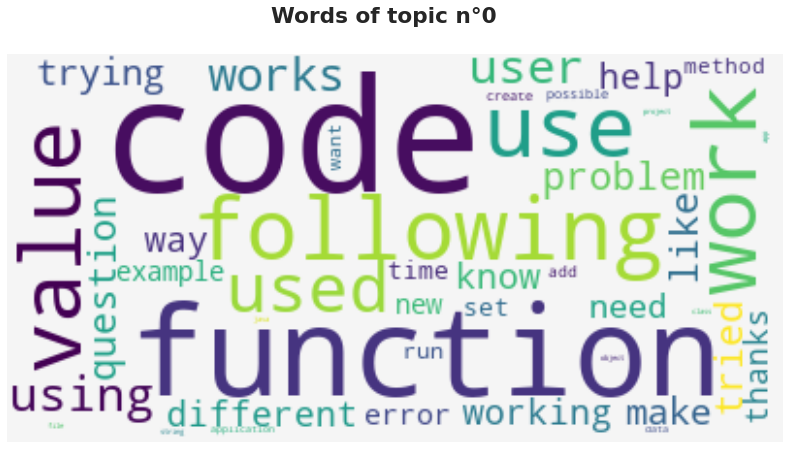

In [ ]:
idx_topic = 0
fact.show_wordcloud(idx_topic)

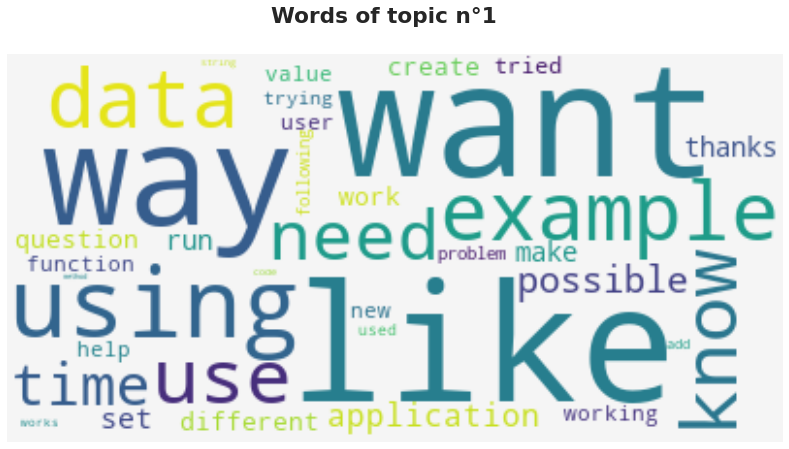

In [ ]:
idx_topic = 1
fact.show_wordcloud(idx_topic)

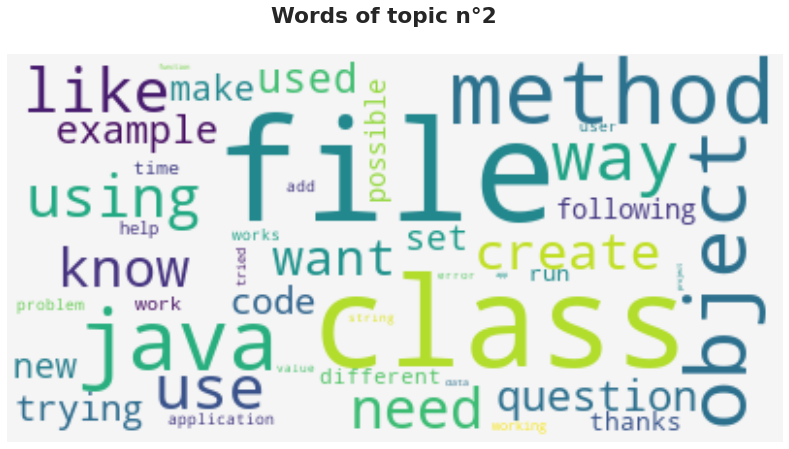

In [ ]:
idx_topic = 2
fact.show_wordcloud(idx_topic)

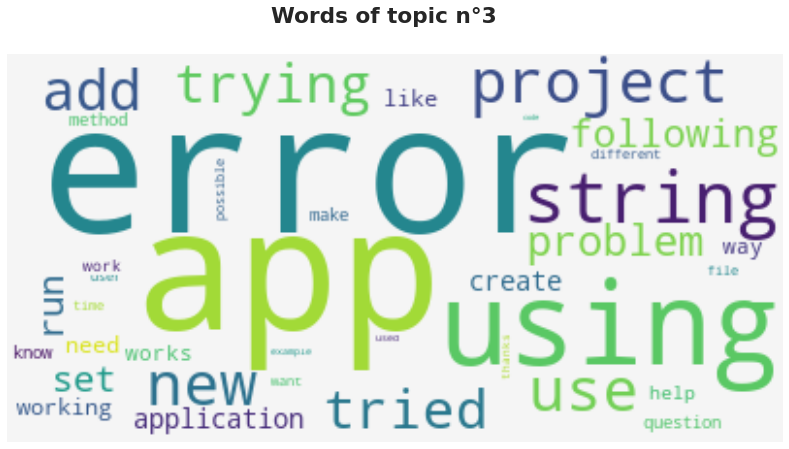

In [ ]:
idx_topic = 3
fact.show_wordcloud(idx_topic)

No clear subject appears, except the topic n°2 that seems to deal with java questions.

<a id="2_4"></a>

### 2.4. Topic modeling analysis - 5 topics and a min-df of 5%

In [ ]:
nb_topics = 5
bow.set_params(**{"ngram_range": (1, 3)})
bow.set_params(**{"min_df": 0.05})
lda.set_params(**{"n_components": nb_topics})
fact = TextFactorization(vectorizer=bow, model=lda)
fact.fit(X_mini.body)
score = fact.coherence_score()

In [ ]:
nb_words = 20
print("{} topics found via LDA - Coherence score = {}"\
      .format(nb_topics, score))
fact.print_topics(n_top_words=nb_words)

5 topics found via LDA - Coherence score = 0.7657842717363017

Topic 0:
using like way use user work set new need add solution project change create question line case trying want edit

Topic 1:
file application know list use need different server run want way time using like create possible problem able read used

Topic 2:
class method string java code python object type value use used time question know like example following using need way

Topic 3:
want like function example data code using way possible use know make following thanks used work help works question able

Topic 4:
error app code following tried using trying problem getting run working try project help new work works server application file


One more time, no clear subject appears. It's even worse with java and python beeing in the same topic.


<a id="2_5"></a>

### 2.5. Topic modeling analysis - 6 topics and a min-df of 7%

In [ ]:
nb_topics = 6
bow.set_params(**{"ngram_range": (1, 3)})
bow.set_params(**{"min_df": 0.07})
lda.set_params(**{"n_components": nb_topics})
fact = TextFactorization(vectorizer=bow, model=lda)
fact.fit(X_mini.body)
score = fact.coherence_score()

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [ ]:
nb_words = 20
print("{} topics found via LDA - Coherence score = {}"\
      .format(nb_topics, score))
fact.print_topics(n_top_words=nb_words)

6 topics found via LDA - Coherence score = 0.7680474772566273

Topic 0:
like want way value possible create using know example need make thanks use trying code run problem works tried question

Topic 1:
file app new problem run want error trying tried know need using code way works following example thanks question create

Topic 2:
using error application following code trying tried run problem use works way thanks make work new create need know set

Topic 3:
code data time used question using following like use know example value thanks problem way make work trying works tried

Topic 4:
use function work need new example code know want using works tried way make question problem possible following like trying

Topic 5:
method class set use way using know need want question like example create code new following make problem thanks works


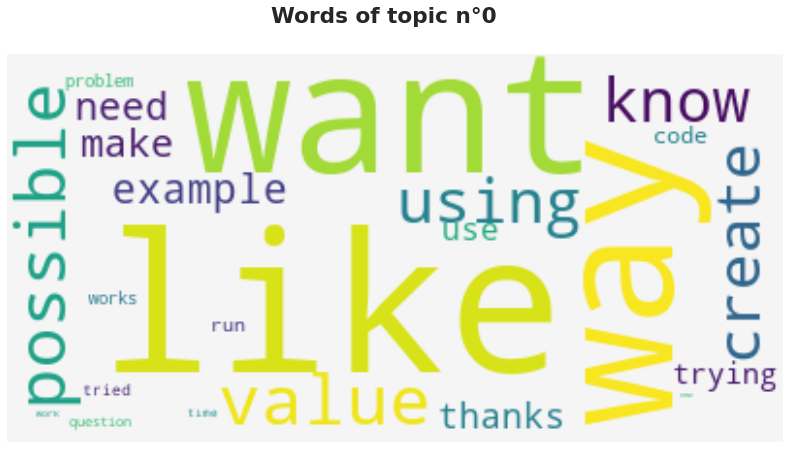

In [ ]:
idx_topic = 0
fact.show_wordcloud(idx_topic)

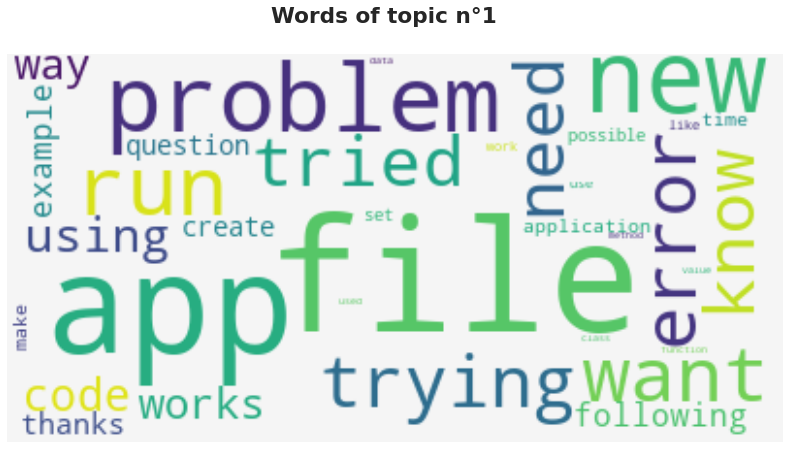

In [ ]:
idx_topic = 1
fact.show_wordcloud(idx_topic)

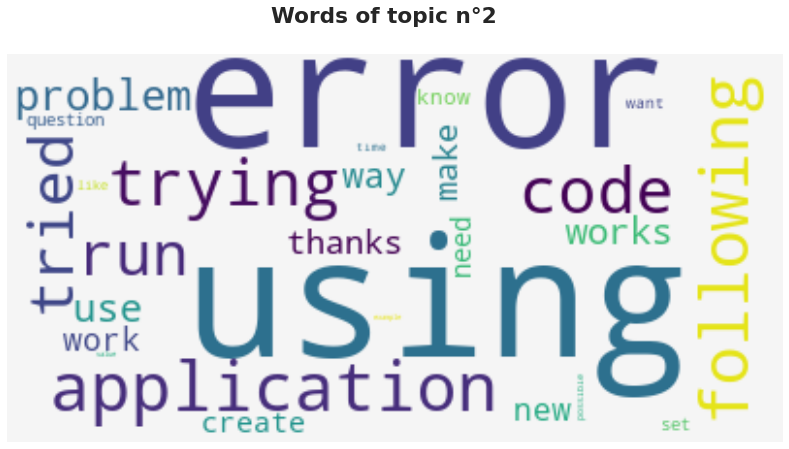

In [ ]:
idx_topic = 2
fact.show_wordcloud(idx_topic)

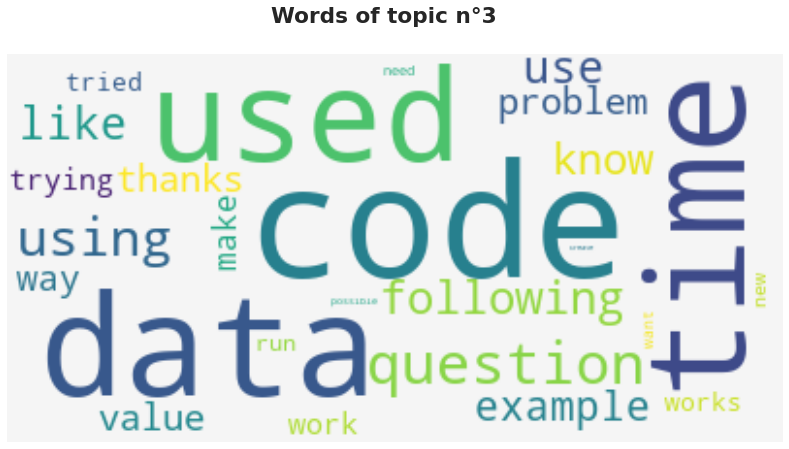

In [ ]:
idx_topic = 3
fact.show_wordcloud(idx_topic)

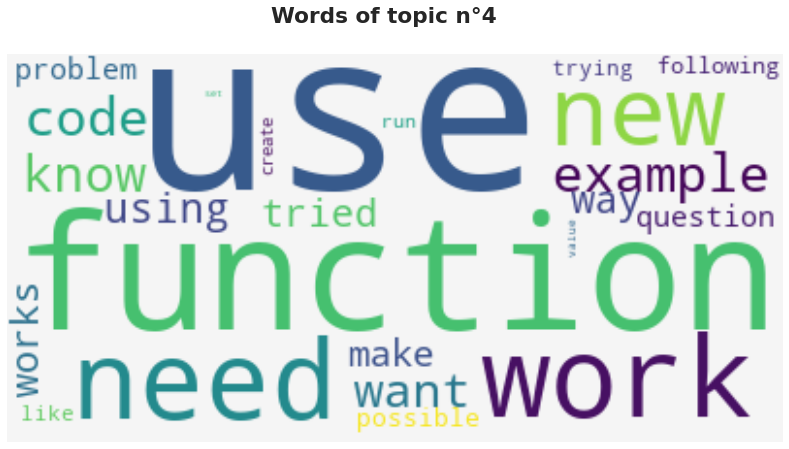

In [ ]:
idx_topic = 4
fact.show_wordcloud(idx_topic)

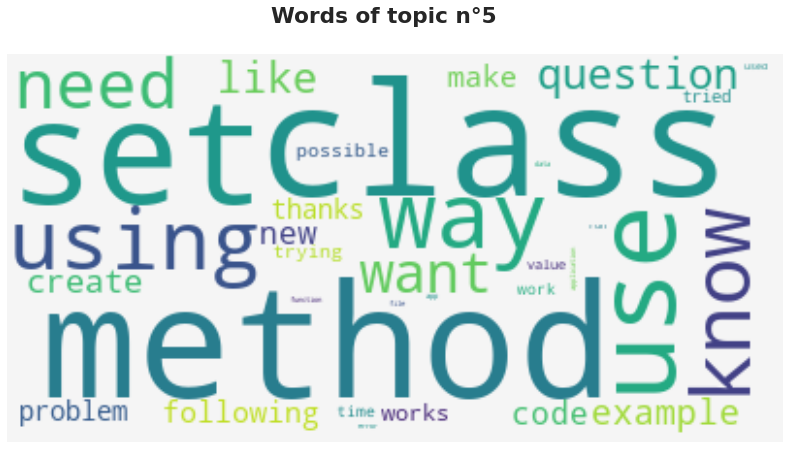

In [ ]:
idx_topic = 5
fact.show_wordcloud(idx_topic)

<a id="2_6"></a>

### 2.6. pyLDAvis visualization - 6 topics and a min-df of 7%

Interactive visualisation with pyLDAvis.

In [ ]:
pyLDAvis.sklearn.prepare(fact.model, fact.matrix_docwords, fact.vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.166635 -0.069505       1        1  21.750752
4      0.040310  0.039639       2        1  20.331755
2     -0.134386  0.165035       3        1  19.336846
3      0.055226  0.189944       4        1  17.230654
5      0.174789 -0.160670       5        1  11.341772
1     -0.302574 -0.164443       6        1  10.008221, topic_info=      Term         Freq        Total Category  logprob  loglift
8     file  3067.000000  3067.000000  Default  30.0000  30.0000
0      app  1988.000000  1988.000000  Default  29.0000  29.0000
12    like  5111.000000  5111.000000  Default  28.0000  28.0000
14  method  1959.000000  1959.000000  Default  27.0000  27.0000
2    class  1949.000000  1949.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
26     use     7.701100  4183.388271   Topic6  -6.8682  -3.9958
12    like     8.257791  5111.543209   Topic6  -6.7984  -4.1263
27    used     0.184149  1249.107455   Topic6 -10.6015  -6.5204
29   value     0.182634  1421.606389   Topic6 -10.6098  -6.6580
5     data     0.182757  1667.394720   Topic6 -10.6091  -6.8169

[218 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         6  0.999520          app
1         3  0.976819  application
1         6  0.023189  application
2         5  0.999593        class
3         1  0.021536         code
...     ...       ...          ...
33        2  0.488244        works
33        3  0.281787        works
33        4  0.097649        works
33        5  0.036270        works
33        6  0.057659        works

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 6, 2])

<a id="2_7"></a>

### 2.7. TSNE visualization - 6 topics and a min-df of 7%

Visualization of documents by topics with TSNE

In [ ]:
X_reduc = []
list_perplexity = [10, 30, 50, 100, 250, 500]
for perplexity in list_perplexity:
    reduc = TSNE(perplexity=perplexity, n_jobs=-1, random_state=42)
    X_reduc.append(pd.DataFrame(reduc.fit_transform(fact.matrix_docwords),
                                index=X_mini.index,
                                columns=["Axe 1", "Axe 2"]))

In [ ]:
X_main_topic = np.argmax(fact.matrix_doctopics, axis=1)

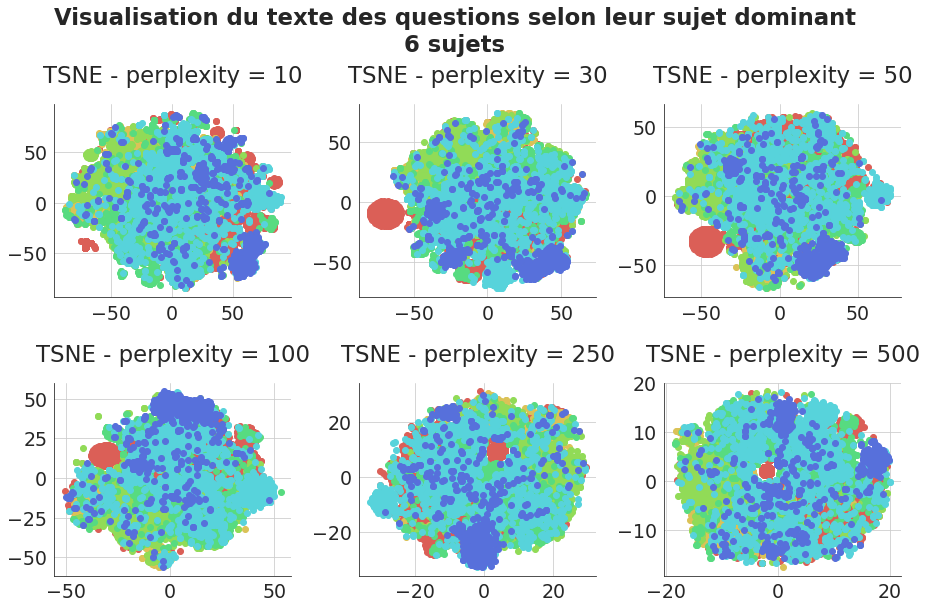

In [ ]:
graph_title = "Visualisation du texte des questions selon leur sujet dominant\n6 sujets"
graph = sfg.MyGraph(graph_title, y_title=0.95, nblin=2, nbcol=3,
                    color_palette="hls", ncolors=8, figsize=(13,9))
for i in range(len(list_perplexity)):
    xreduc = X_reduc[i]
    for t in range(nb_topics):
        graph.add_scatter(xreduc[X_main_topic==t].iloc[:, 0], xreduc[X_main_topic==t].iloc[:, 1],
                          uniquecolor=graph.liste_couleurs[t],
                          subtitle="TSNE - perplexity = {}".format(list_perplexity[i]),
                          multi_index=i+1)
fig, ax = graph.fig, graph.ax
save_fig("ml05_02_tsne_texte_6topics")
plt.show()

Topics are pretty well separated. But it's almost impossible to identify their subject with the top words. And some words are similar to all topics.  
The more frequent words may need to be remove by the use of the hyperparameter max_df. Moreover, I may need to adjust alpha and beta hyperparameters to get better topics and word concentrations.  
I run an hyperparameter optimization with the hyperopt library.

---
<a id='3_0'></a>

## <font color=blue>3. LDA - Optimisation of hyperparameters with hyperopt</font>

### 3.1. Running Hyperopt

In [ ]:
ITERATION = 0
OUT_FILE = ""

In [ ]:
def objective_fact(params):
    global ITERATION, OUT_FILE
    ITERATION += 1

    fact.set_params(**params)

    start_time = timer()
    fact.fit(X_mini.body)
    fact_time = timer() - start_time
    
    score = fact.coherence_score()
    loss = -score

    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([score, fact_time, params, ITERATION])
    of_connection.close()
    
    return {"loss": loss, "fact_time": fact_time, "params": params,
            "iteration": ITERATION, "status": STATUS_OK}

In [ ]:
def run_fact_optimization(fact_file, max_evals=100):
    global OUT_FILE
    OUT_FILE = fact_file
    of_connection = open(OUT_FILE, "w")  # Write the headers to the file
    writer = csv.writer(of_connection)
    writer.writerow(["loss", "factorization_time", "params", "iteration"])
    of_connection.close()
    
    global ITERATION
    ITERATION = 0

    trials = Trials()
    
    best_param = fmin(objective_fact, space_fact,
                      algo=tpe.suggest, trials=trials,
                      max_evals=max_evals, rstate=np.random.RandomState(42))
    
    list_losses = [t["result"]["loss"] for t in trials.trials]
    idx_min = np.argmin(list_losses)

    print("Hyperparameters optimization done")
    print("Best coherence score = {}"\
          .format(-trials.trials[idx_min]["result"]["loss"]))
    print("Calculation time = {}"\
          .format(trials.trials[idx_min]["result"]["fact_time"]))
    print("Best coherence score obtained after {} iterations"\
          .format(trials.trials[idx_min]["result"]["iteration"]))
    print("")

In [ ]:
fact = TextFactorization(vectorizer=bow, model=lda)

In [ ]:
fact.get_params().keys()

dict_keys(['model__batch_size', 'model__doc_topic_prior', 'model__evaluate_every', 'model__learning_decay', 'model__learning_method', 'model__learning_offset', 'model__max_doc_update_iter', 'model__max_iter', 'model__mean_change_tol', 'model__n_components', 'model__n_jobs', 'model__perp_tol', 'model__random_state', 'model__topic_word_prior', 'model__total_samples', 'model__verbose', 'model', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__preprocessor', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__vocabulary', 'vectorizer'])

In [ ]:
space_fact = {
    "vectorizer__ngram_range": hp.choice("ngram_range",
                                         [(1, 1), (1, 2), (1, 3)]),
    "vectorizer__min_df": hp.uniform("min_df", 0.01, 0.05),
    "vectorizer__max_df": hp.uniform("max_df", 0.95, 0.99),
    "model__n_components" : hp.choice("n_components",
                                      np.arange(2, 21, 1, dtype=int)),
    "model__doc_topic_prior": hp.choice("alpha",
                                        [0.05, 0.1, 0.5, 1, 5, 10]),
    "model__topic_word_prior": hp.choice("beta",
                                         [0.05, 0.1, 0.5, 1, 5, 10])}

In [ ]:
fact_file = "hyperopt_lda.csv"
run_fact_optimization(fact_file, max_evals=100)

100%|██████████| 100/100 [51:51<00:00, 31.12s/it, best loss: -0.7753213068506005]
Hyperparameters optimization done
Best coherence score = 0.7753213068506005
Calculation time = 17.4194502499995
Best coherence score obtained after 73 iterations



<a id="3_2"></a>

### 3.2. Results analysis

In [ ]:
fact_results = pd.read_csv("hyperopt_lda.csv")
fact_results.head()

loss  ...  iteration
0  0.585004  ...          1
1  0.755036  ...          2
2  0.755231  ...          3
3  0.405331  ...          4
4  0.607860  ...          5

[5 rows x 4 columns]

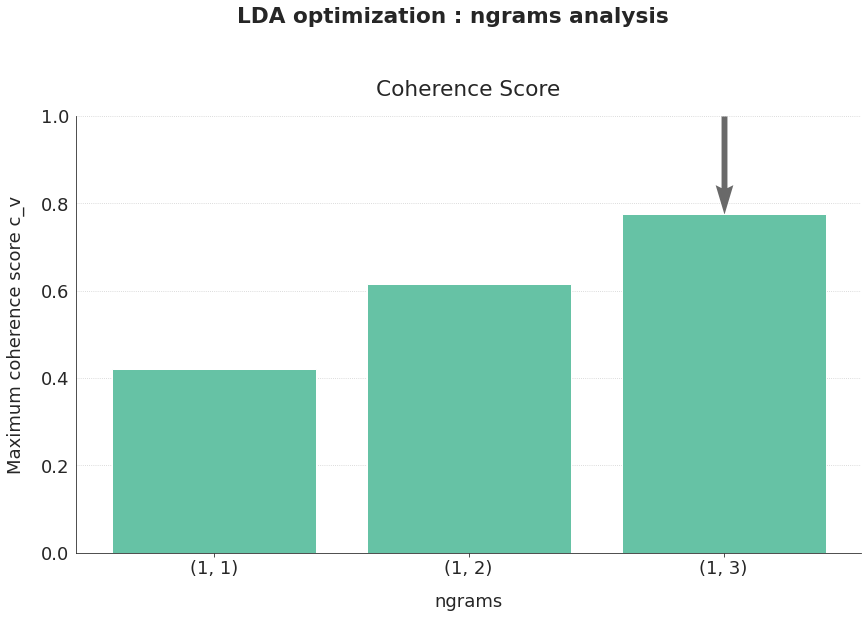

In [ ]:
fig, ax = graph_discret_coherencescore(fact_results, "bow_ngrams",
                                       "ngrams", ymin=0, ymax=1)
plt.show()

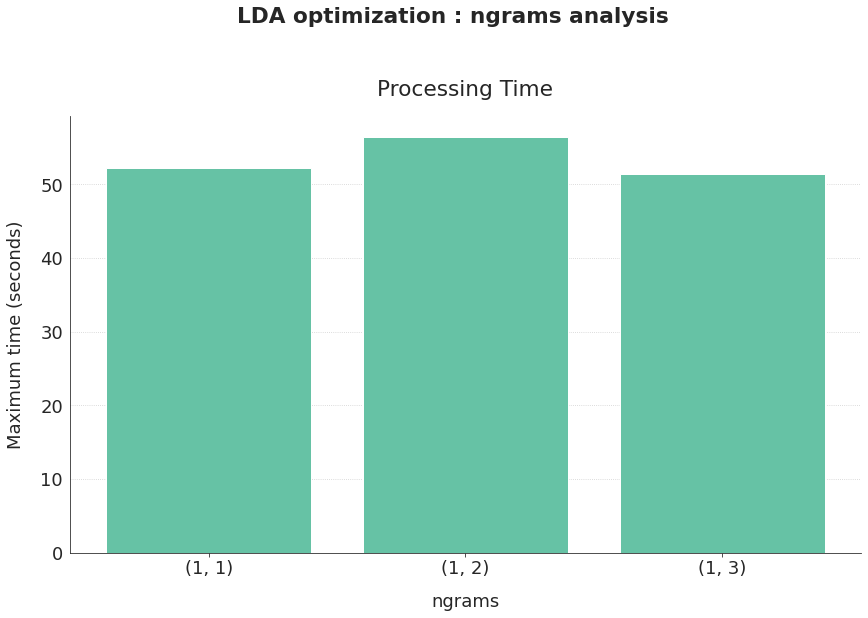

In [ ]:
fig, ax = graph_discret_coherencescore(fact_results, "bow_ngrams",
                                       "ngrams", show_time=True)
plt.show()

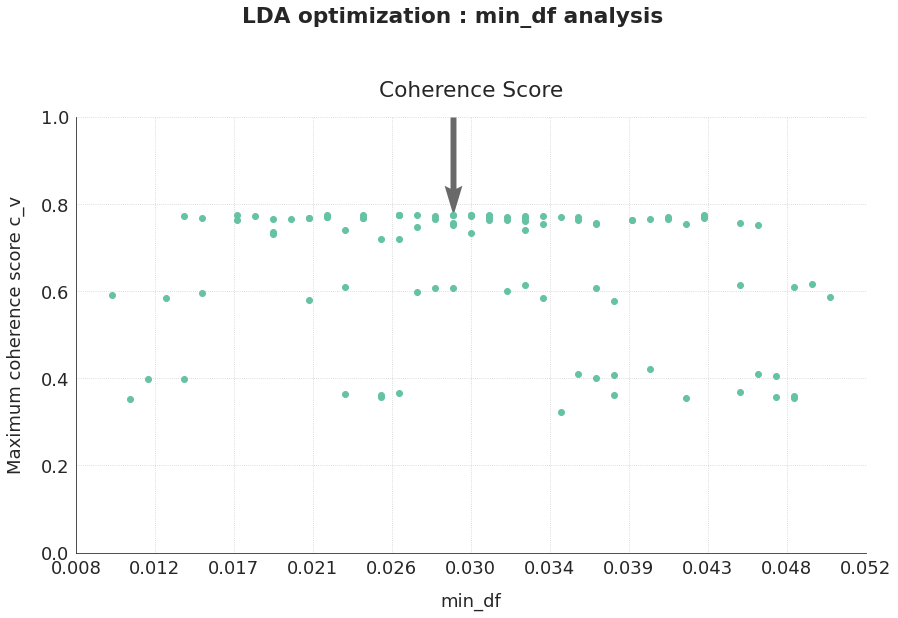

In [ ]:
fig, ax = graph_continu_coherencescore(fact_results, "bow_mindf",
                                       "min_df", preview=True)
plt.show()

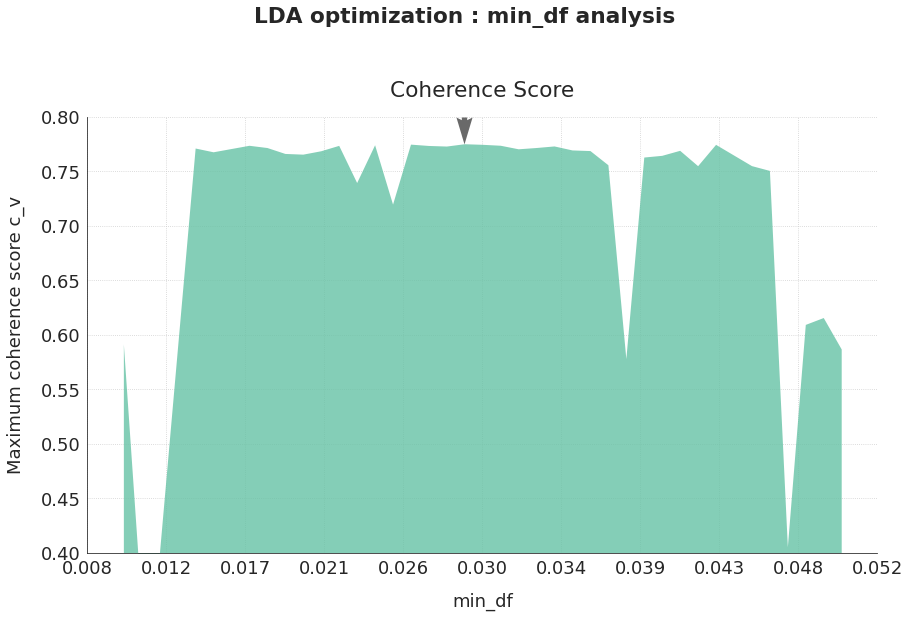

In [ ]:
fig, ax = graph_continu_coherencescore(fact_results, "bow_mindf",
                                       "min_df", ymin=0.4, ymax=0.8)
plt.show()

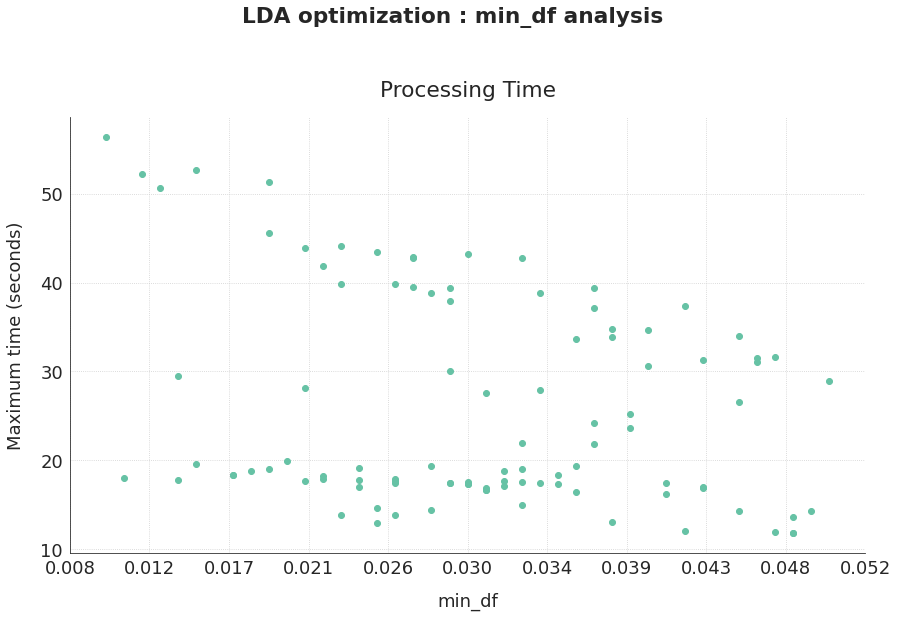

In [ ]:
fig, ax = graph_continu_coherencescore(fact_results, "bow_mindf",
                                       "min_df", show_time=True, preview=True)
plt.show()

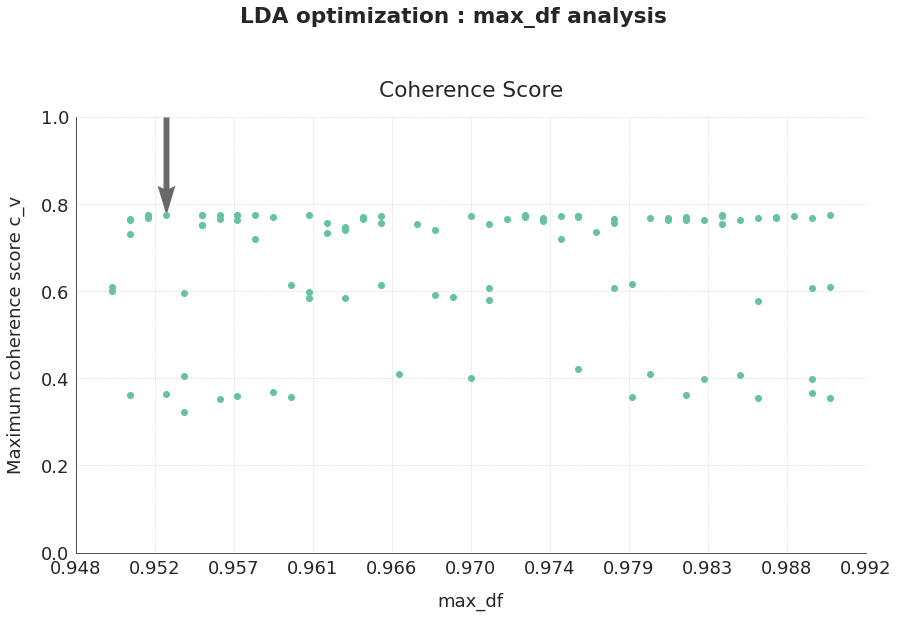

In [ ]:
fig, ax = graph_continu_coherencescore(fact_results, "bow_maxdf",
                                       "max_df", preview=True)
plt.show()

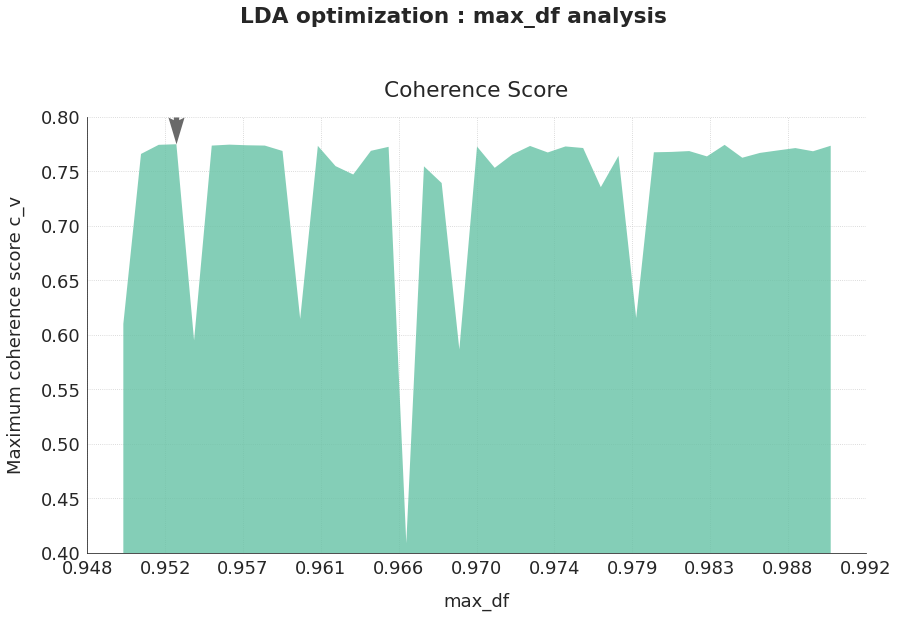

In [ ]:
fig, ax = graph_continu_coherencescore(fact_results, "bow_maxdf",
                                       "max_df", ymin=0.4, ymax=0.8)
plt.show()

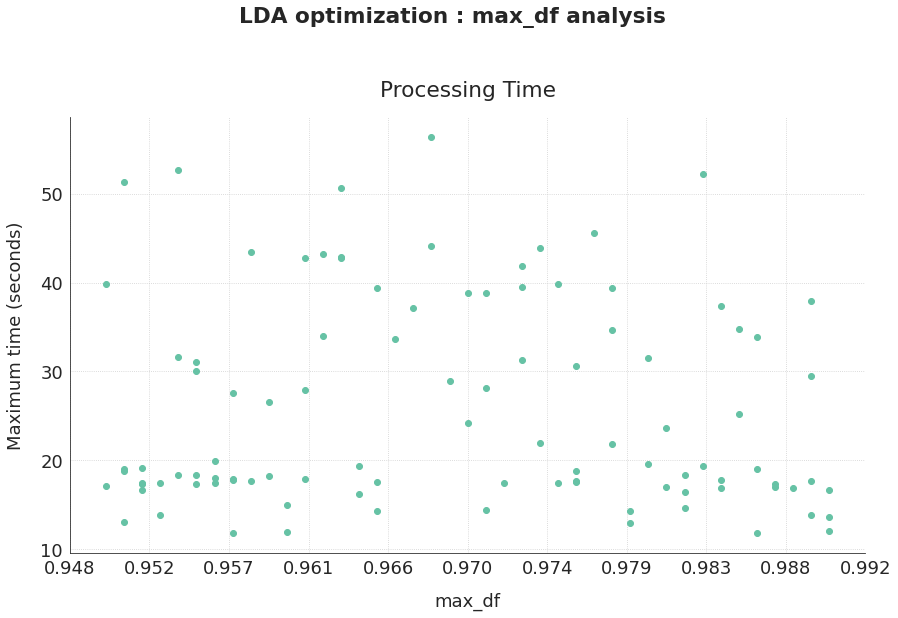

In [ ]:
fig, ax = graph_continu_coherencescore(fact_results, "bow_maxdf",
                                       "max_df", show_time=True, preview=True)
plt.show()

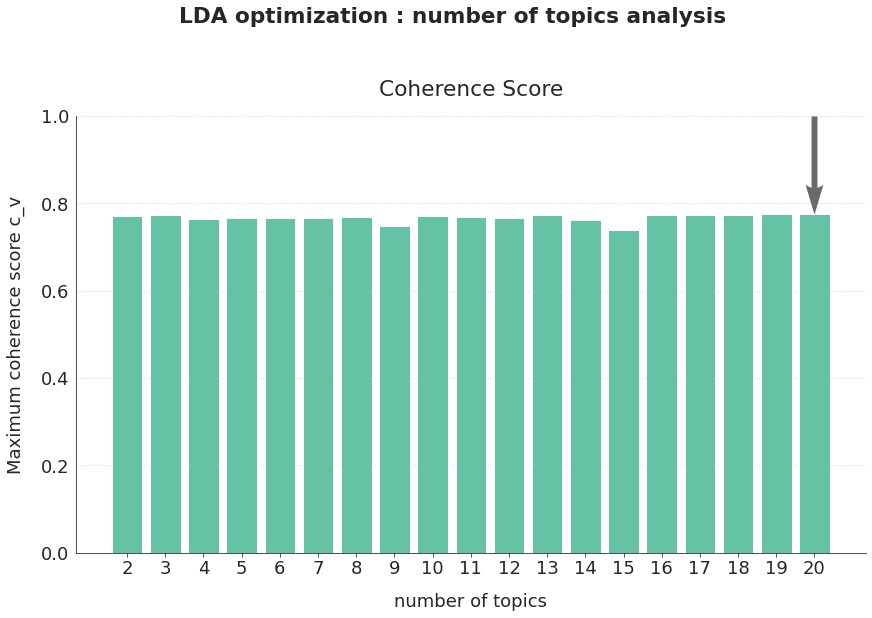

In [ ]:
fig, ax = graph_discret_coherencescore(fact_results, "lda_ntopics",
                                       "number of topics")
plt.show()

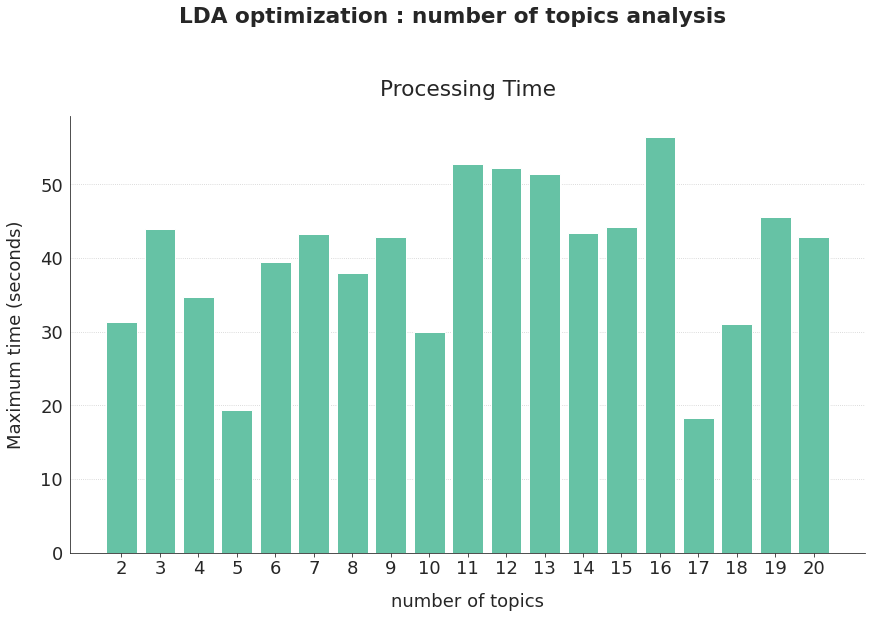

In [ ]:
fig, ax = graph_discret_coherencescore(fact_results, "lda_ntopics",
                                       "number of topics", show_time=True)
plt.show()

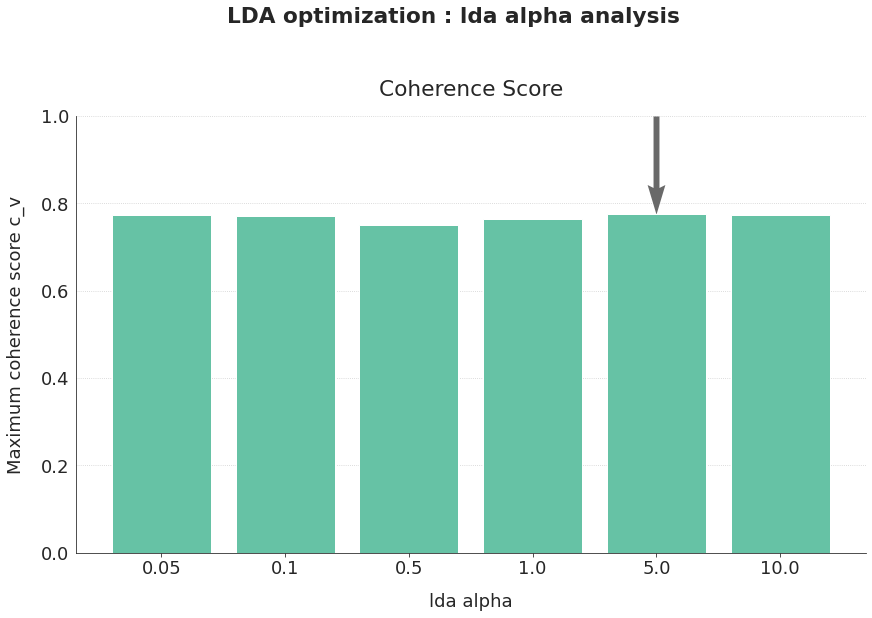

In [ ]:
fig, ax = graph_discret_coherencescore(fact_results, "lda_alpha",
                                       "lda alpha")
plt.show()

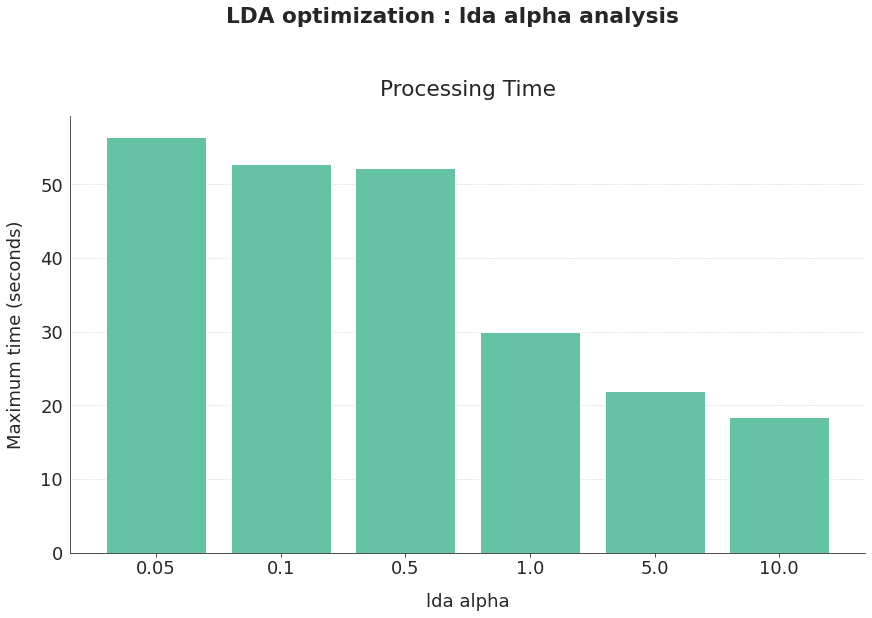

In [ ]:
fig, ax = graph_discret_coherencescore(fact_results, "lda_alpha",
                                       "lda alpha", show_time=True)
plt.show()

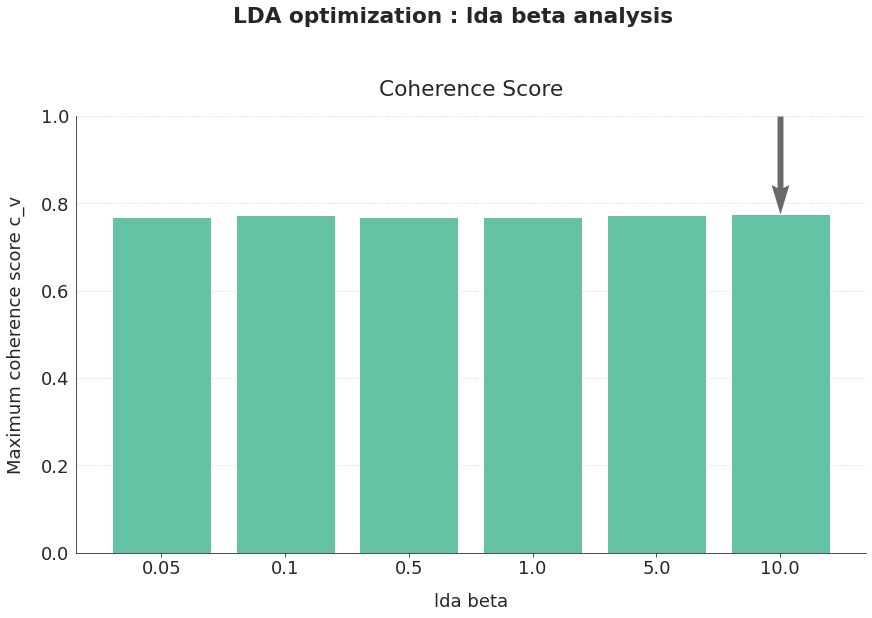

In [ ]:
fig, ax = graph_discret_coherencescore(fact_results, "lda_beta",
                                       "lda beta")
plt.show()

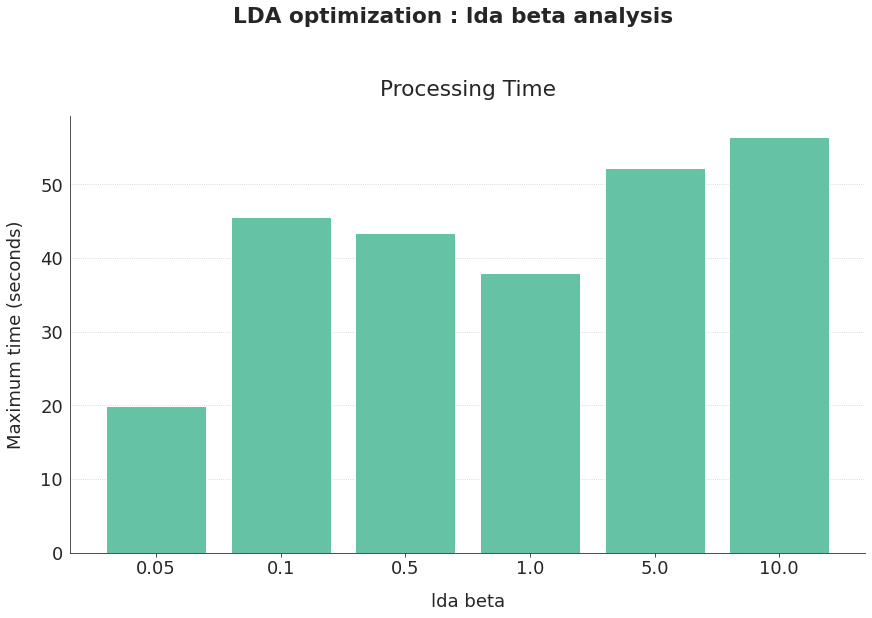

In [ ]:
fig, ax = graph_discret_coherencescore(fact_results, "lda_beta",
                                       "lda beta", show_time=True)
plt.show()

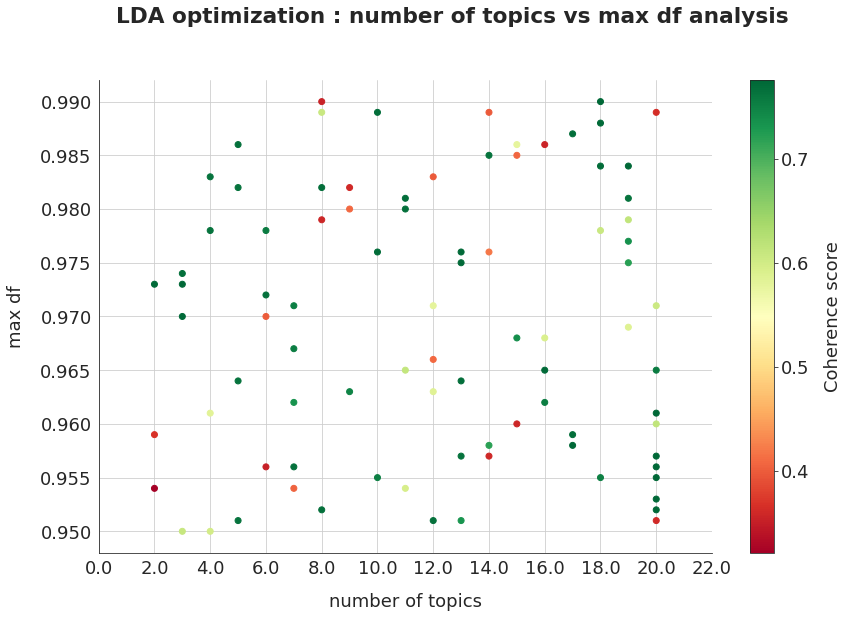

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results, "lda_ntopics", "bow_maxdf",
                                     "number of topics", "max df",
                                     xmin=0, xmax=22, xstep=2)
plt.show()

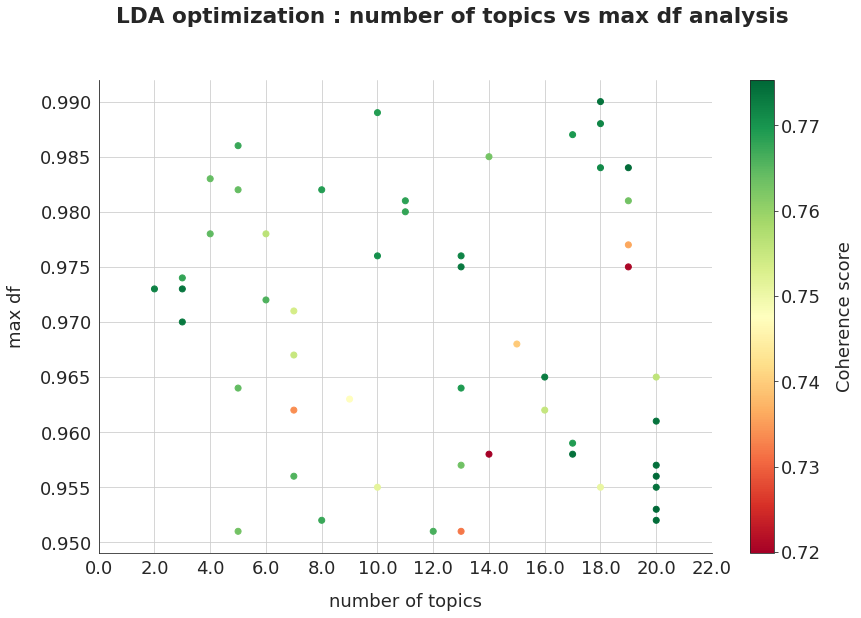

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results, "lda_ntopics", "bow_maxdf",
                                     "number of topics", "max df", vmin=0.7,
                                     xmin=0, xmax=22, xstep=2)
plt.show()

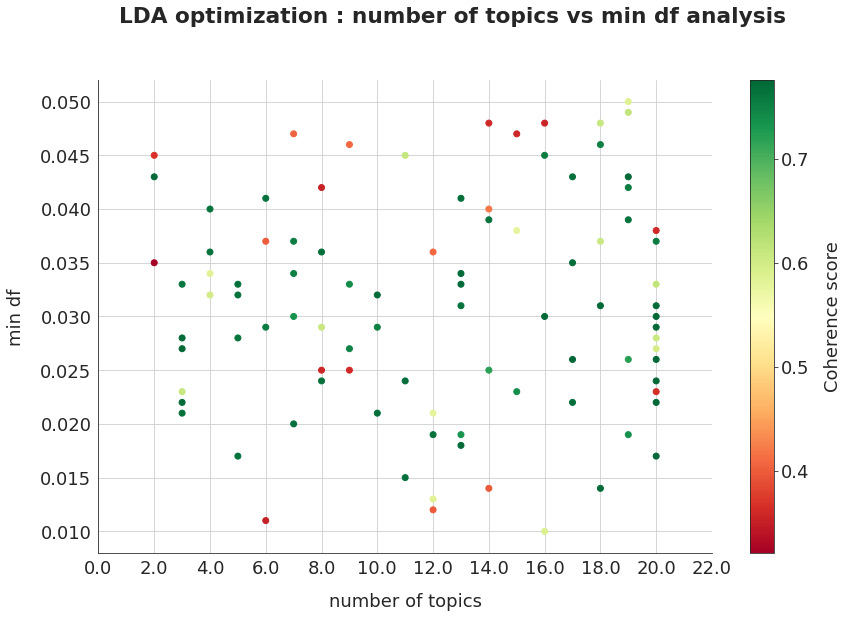

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results, "lda_ntopics", "bow_mindf",
                                     "number of topics", "min df",
                                     xmin=0, xmax=22, xstep=2)
plt.show()

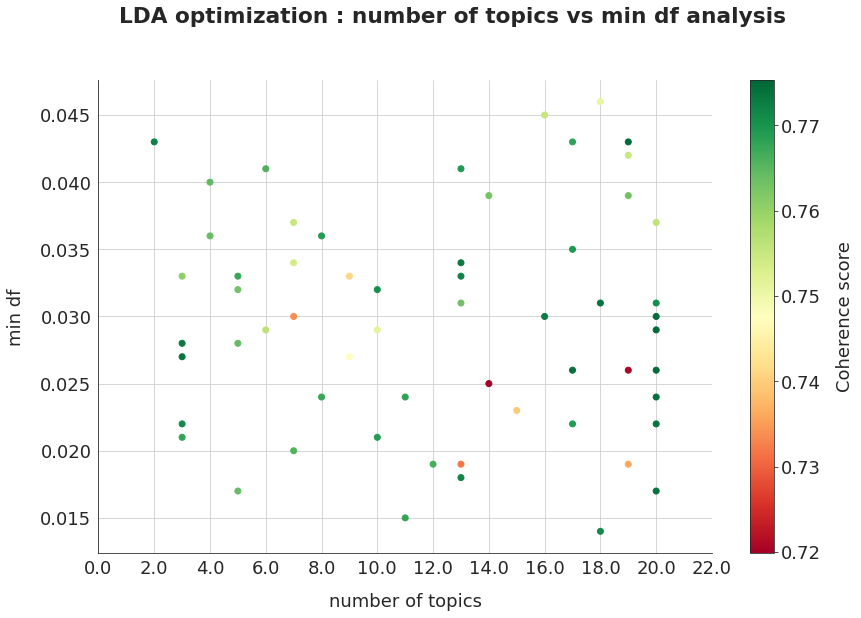

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results, "lda_ntopics", "bow_mindf",
                                     "number of topics", "min df", vmin=0.7,
                                     xmin=0, xmax=22, xstep=2)
plt.show()

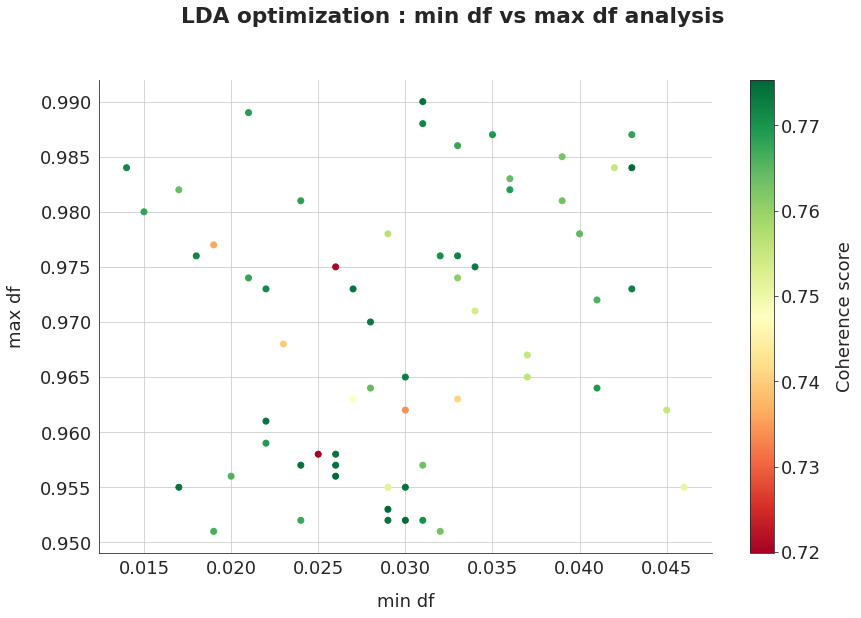

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results, "bow_mindf", "bow_maxdf",
                                     "min df", "max df", vmin=0.7)
plt.show()

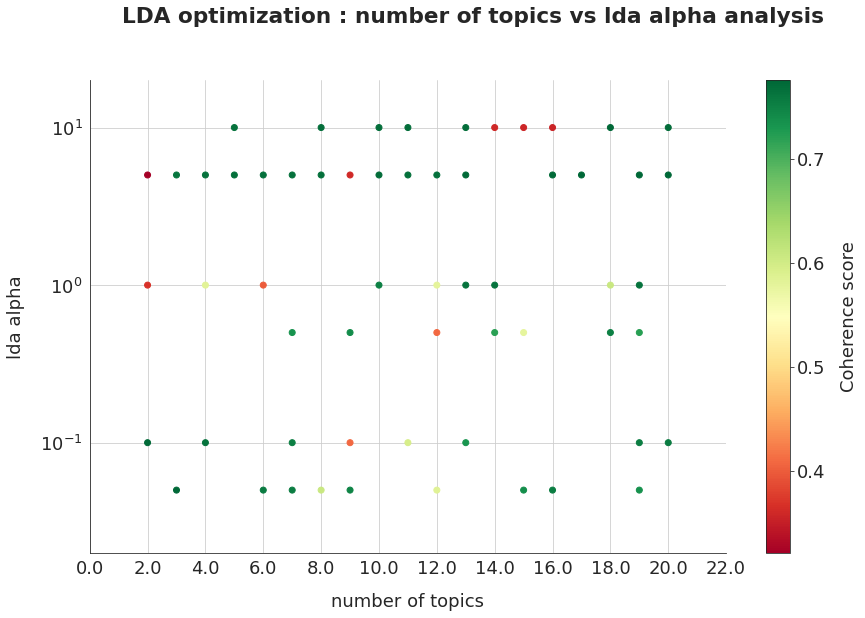

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results, "lda_ntopics", "lda_alpha",
                                     "number of topics", "lda alpha",
                                     xmin=0, xmax=22, xstep=2,
                                     ymin=0.02, ymax=20, ylog=True)
plt.show()

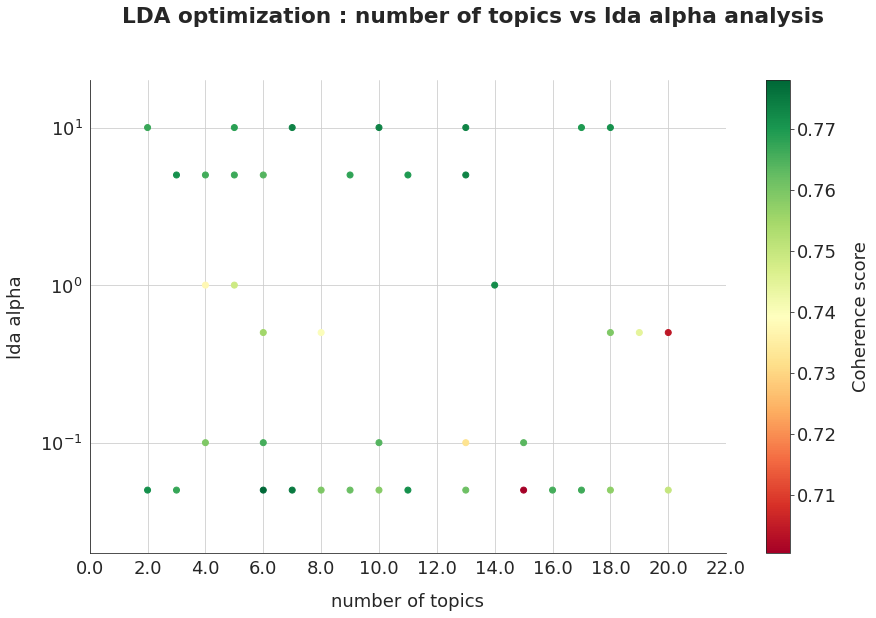

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results, "lda_ntopics", "lda_alpha",
                                     "number of topics", "lda alpha", vmin=0.7,
                                     xmin=0, xmax=22, xstep=2,
                                     ymin=0.02, ymax=20, ylog=True)
plt.show()

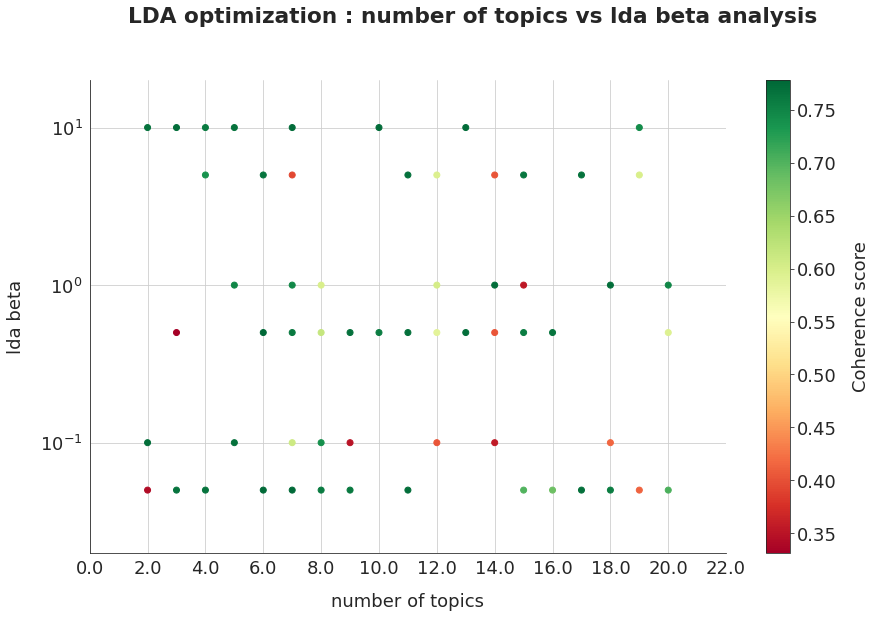

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results, "lda_ntopics", "lda_beta",
                                     "number of topics", "lda beta",
                                     xmin=0, xmax=22, xstep=2,
                                     ymin=0.02, ymax=20, ylog=True)
plt.show()

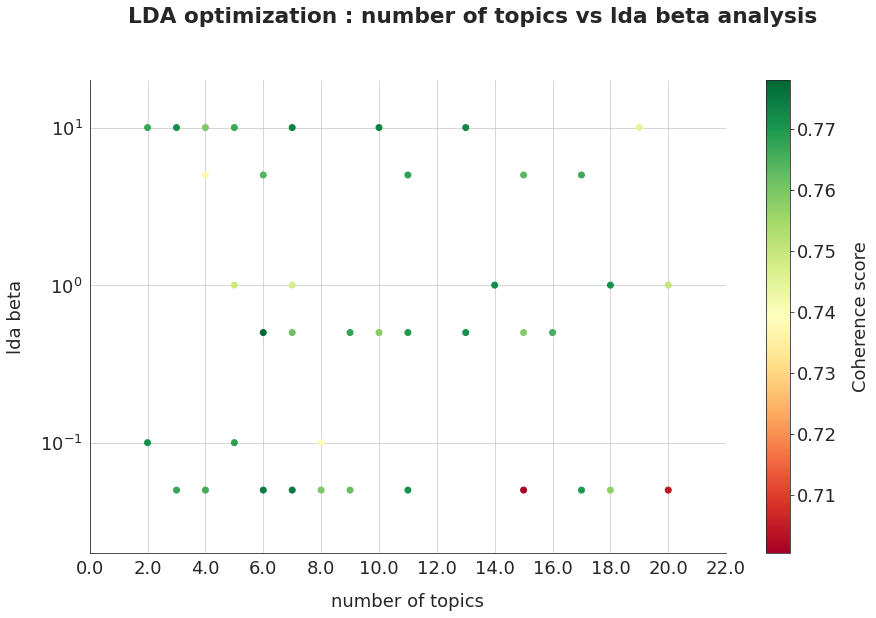

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results, "lda_ntopics", "lda_beta",
                                     "number of topics", "lda beta", vmin=0.7,
                                     xmin=0, xmax=22, xstep=2,
                                     ymin=0.02, ymax=20, ylog=True)
plt.show()

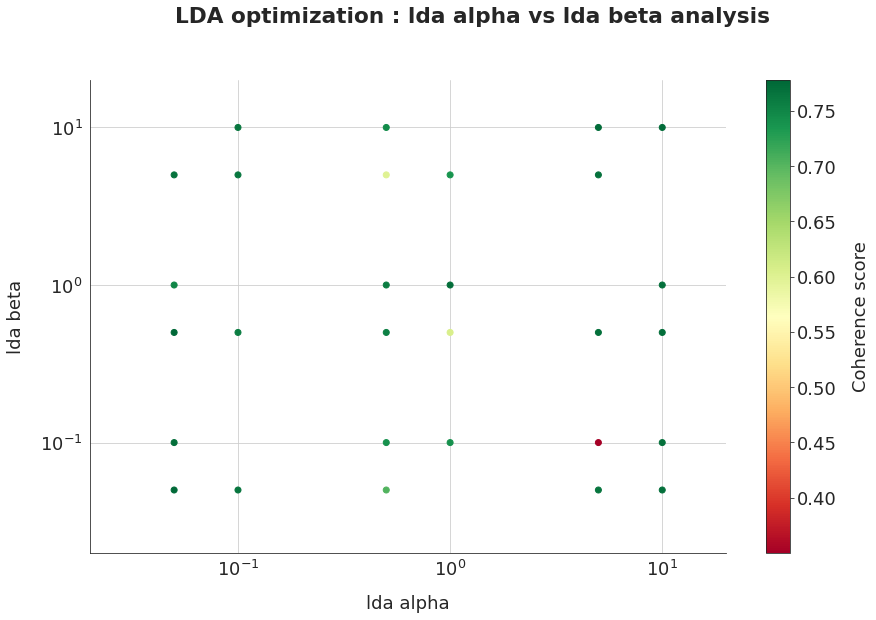

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results, "lda_alpha", "lda_beta",
                                     "lda alpha", "lda beta",
                                     xmin=0.02, xmax=20, xlog=True,
                                     ymin=0.02, ymax=20, ylog=True)
plt.show()

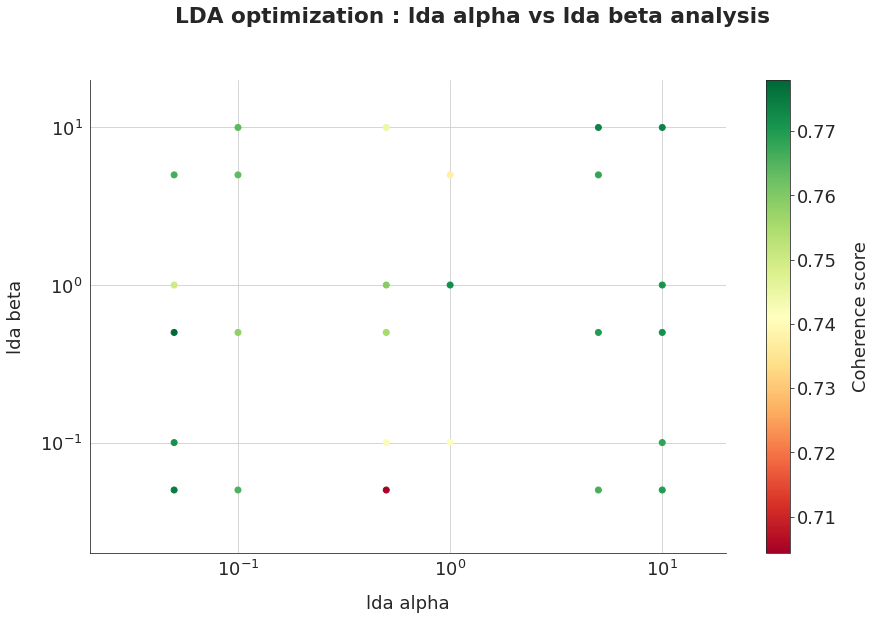

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results, "lda_alpha", "lda_beta",
                                     "lda alpha", "lda beta", vmin=0.7,
                                     xmin=0.02, xmax=20, xlog=True,
                                     ymin=0.02, ymax=20, ylog=True)
plt.show()

The results confirm that adding bigrams and trigrams to the bag of words is the best option.  
I get good coherence scores with 10 and more topics. As I have kept 50 labels, I should split the documents in at least 10 different topics. Otherwise, using the LDA factorization has no interest. I need to go over 20 topics, as 20 topics was the best pick on this run.  
The analysis of the number of topics together with alpha and beta leads me to test alpha and beta values between 1 and 100.    
To get a coherence score over 77%, I will choose min_df betwwen 1.5% and 3.5%, and max_df between 94.5% and 96.5%.  
I run a last optimization with those parameters.

<a id="3_3"></a>

### 3.3. Second optimization run

In [ ]:
space_fact = {
    "vectorizer__ngram_range": (1, 3),
    "vectorizer__min_df": hp.uniform("min_df", 0.015, 0.035),
    "vectorizer__max_df": hp.uniform("max_df", 0.945, 0.965),
    "model__n_components" : hp.choice("n_components",
                                      np.arange(10, 31, 1, dtype=int)),
    "model__doc_topic_prior": hp.loguniform("alpha", np.log(1.0), np.log(100.0)),
    "model__topic_word_prior": hp.loguniform("beta", np.log(1.0), np.log(100.0))}

In [ ]:
fact_file = "hyperopt_lda_v2.csv"
run_fact_optimization(fact_file, max_evals=100)

100%|██████████| 100/100 [41:25<00:00, 24.85s/it, best loss: -0.7774934327699611]
Hyperparameters optimization done
Best coherence score = 0.7774934327699611
Calculation time = 23.18403695899906
Best coherence score obtained after 72 iterations



In [ ]:
fact_results2 = get_fact_results("hyperopt_lda_v2.csv")
fact_results2.head()

loss  factorization_time  iteration  ... lda_ntopics  lda_alpha   lda_beta
0  0.772719           17.706567          1  ...          19   9.340592   4.354061
1  0.769967           15.738964          2  ...          24  76.262417   4.555392
2  0.768073           15.464133          3  ...          24  53.487935  79.881795
3  0.740042           25.387457          4  ...          10   1.861194   1.101213
4  0.776949           20.065794          5  ...          23   1.231500  91.503021

[5 rows x 9 columns]

In [ ]:
fact_results2.sort_values(by="loss", ascending=False).head(10)

loss  factorization_time  iteration  ... lda_ntopics  lda_alpha   lda_beta
71  0.777493           23.184037         72  ...          30   1.010034  36.000748
65  0.777376           21.553006         66  ...          30   1.129503  61.042386
25  0.777357           19.878569         26  ...          30   1.544173  60.277031
37  0.777356           20.145685         38  ...          30   1.500895  26.704840
24  0.777321           19.406670         25  ...          30   1.727594  58.086644
68  0.777302           21.754324         69  ...          30   1.133184  28.624949
62  0.777290           18.156268         63  ...          29   3.343976  23.043565
15  0.777281           20.672617         16  ...          30   1.142271  29.427399
26  0.777255           19.426271         27  ...          30   1.751123  61.160813
67  0.777255           19.365612         68  ...          30   1.827690  49.282993

[10 rows x 9 columns]

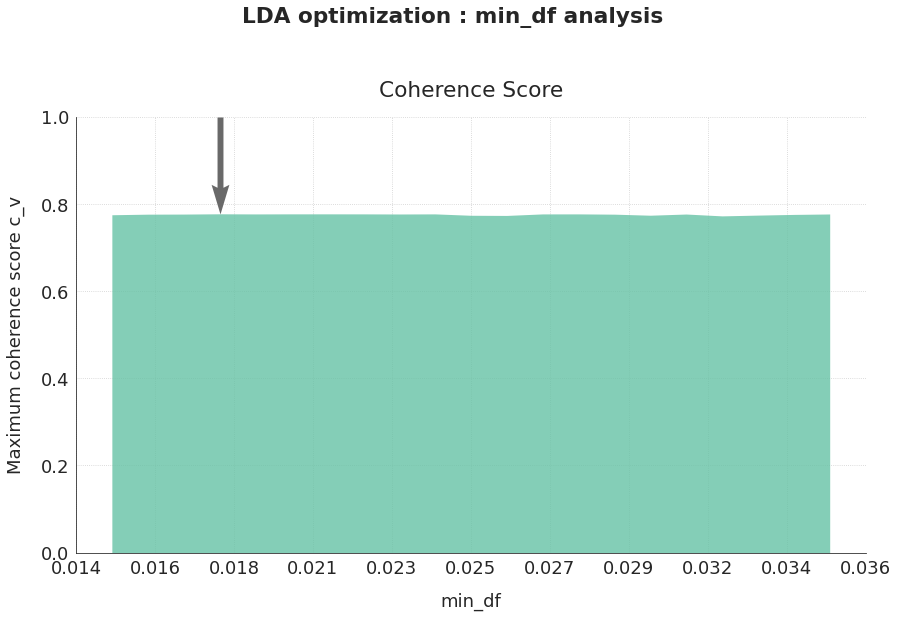

In [ ]:
fig, ax = graph_continu_coherencescore(fact_results2, "bow_mindf",
                                       "min_df")
plt.show()

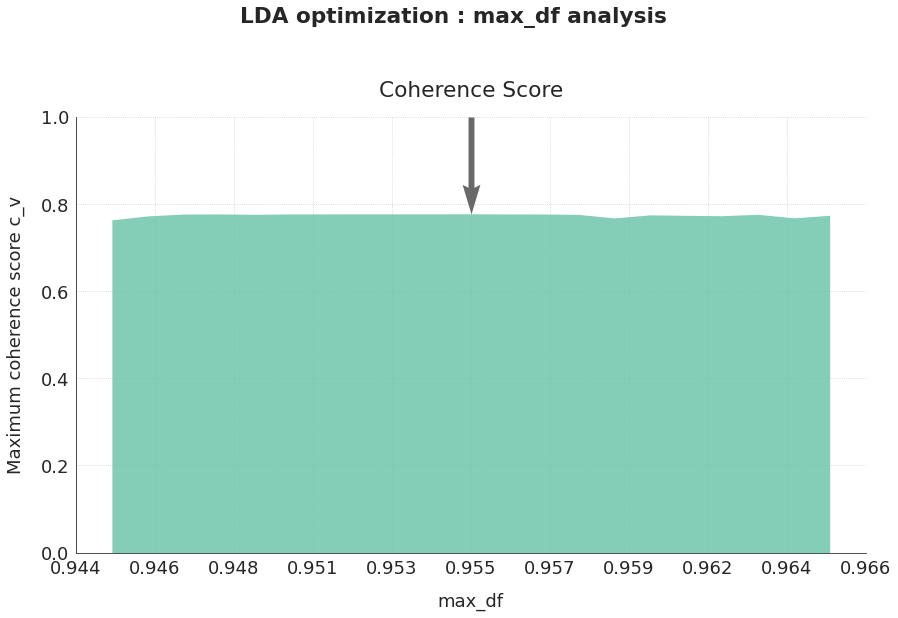

In [ ]:
fig, ax = graph_continu_coherencescore(fact_results2, "bow_maxdf",
                                       "max_df")
plt.show()

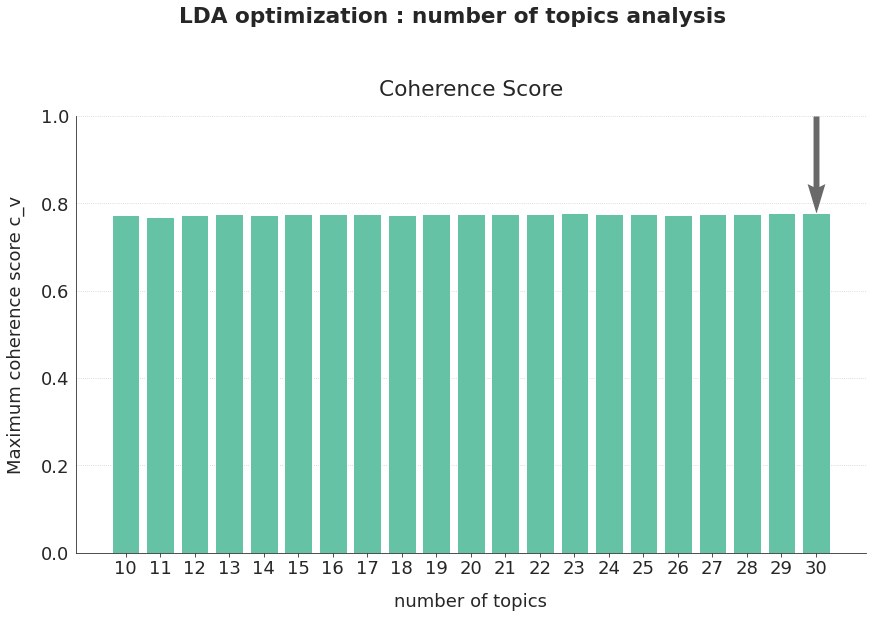

In [ ]:
fig, ax = graph_discret_coherencescore(fact_results2, "lda_ntopics",
                                       "number of topics")
plt.show()

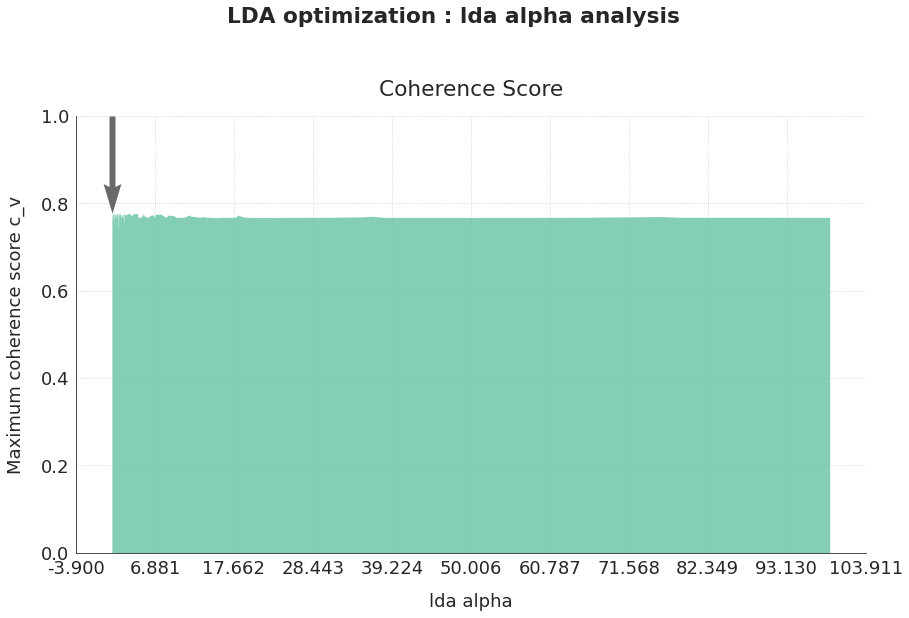

In [ ]:
fig, ax = graph_continu_coherencescore(fact_results2, "lda_alpha",
                                       "lda alpha")
plt.show()

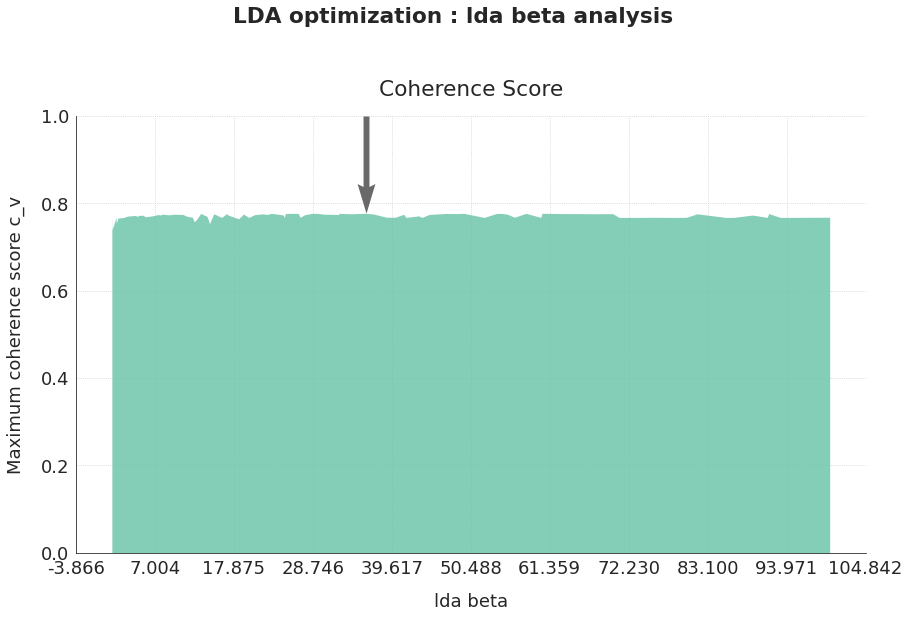

In [ ]:
fig, ax = graph_continu_coherencescore(fact_results2, "lda_beta",
                                       "lda beta")
plt.show()

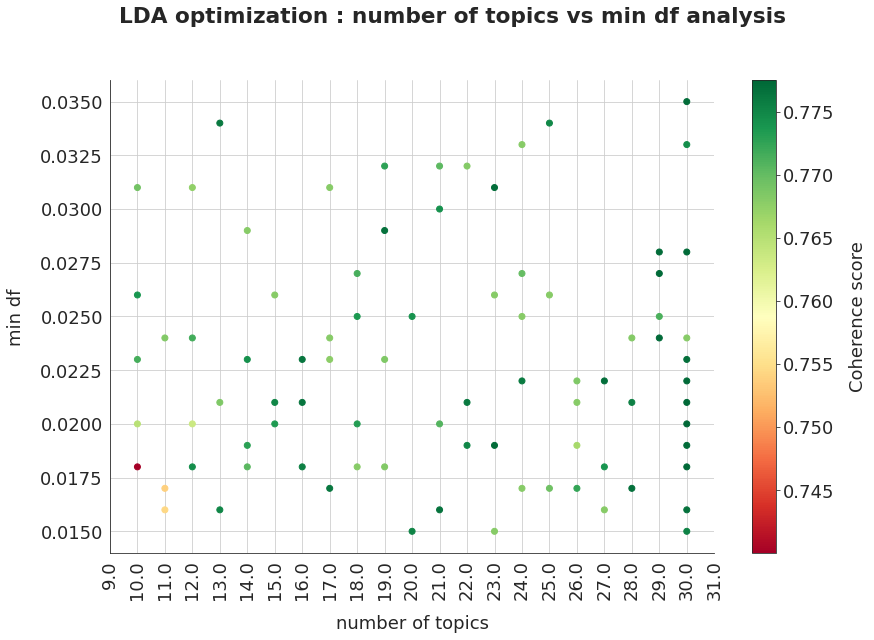

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results2, "lda_ntopics", "bow_mindf",
                                     "number of topics", "min df",
                                     xmin=9, xmax=31, xstep=1, rotation=90)
plt.show()

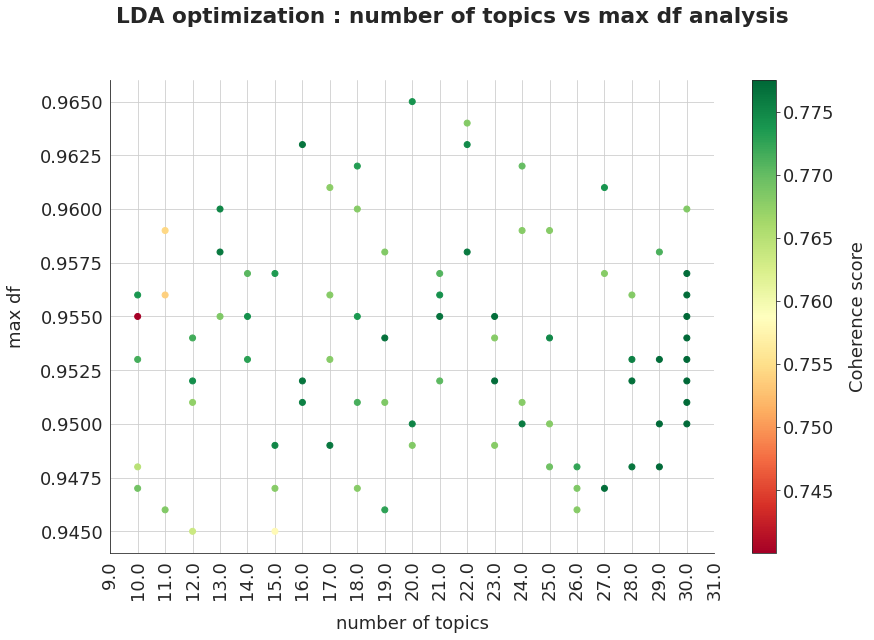

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results2, "lda_ntopics", "bow_maxdf",
                                     "number of topics", "max df",
                                     xmin=9, xmax=31, xstep=1, rotation=90)
plt.show()

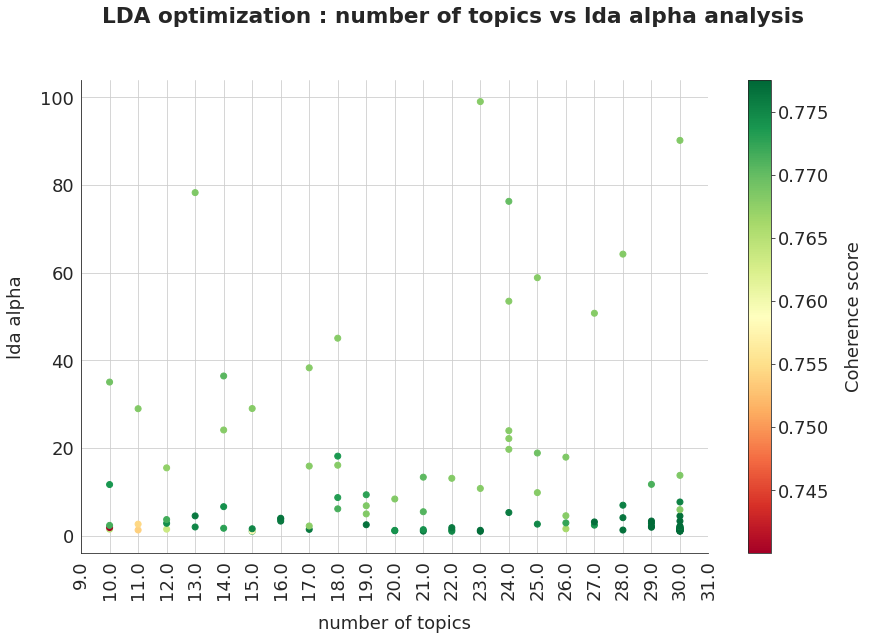

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results2, "lda_ntopics", "lda_alpha",
                                     "number of topics", "lda alpha",
                                     xmin=9, xmax=31, xstep=1, rotation=90)
plt.show()

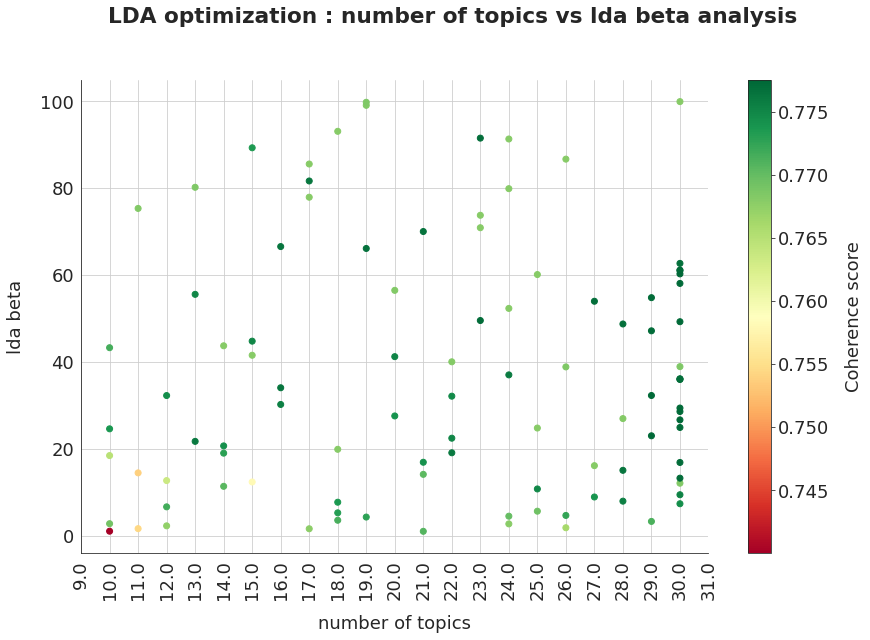

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results2, "lda_ntopics", "lda_beta",
                                     "number of topics", "lda beta",
                                     xmin=9, xmax=31, xstep=1, rotation=90)
plt.show()

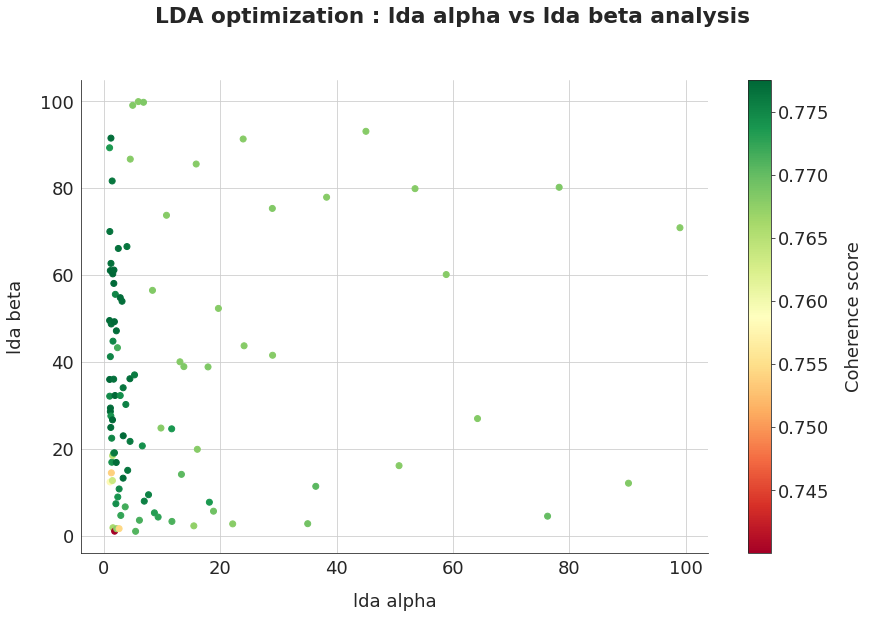

In [ ]:
fig, ax = graph_cross_coherencescore(fact_results2, "lda_alpha", "lda_beta",
                                     "lda alpha", "lda beta")
plt.show()

I look more precisely at the number of topics.

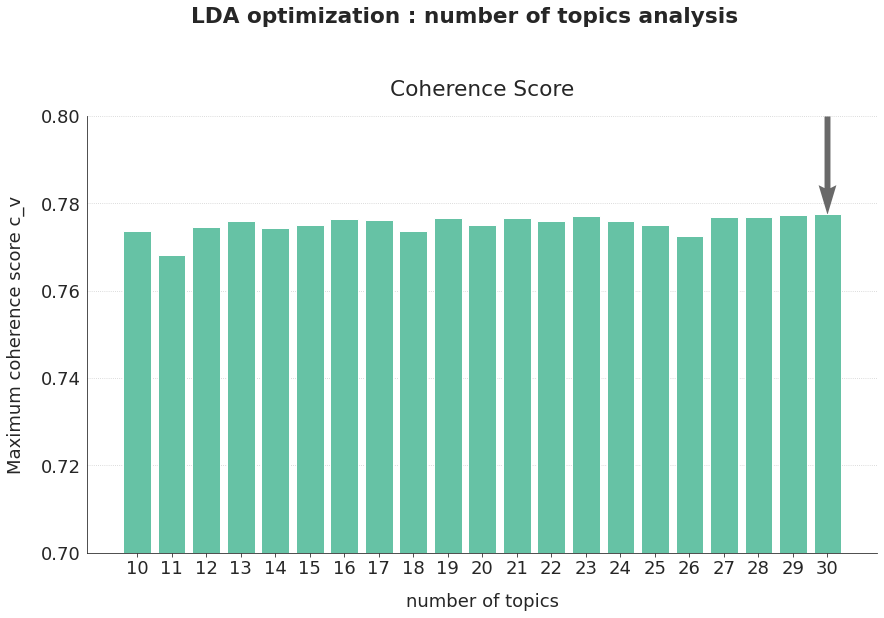

In [ ]:
fig, ax = graph_discret_coherencescore(fact_results2, "lda_ntopics", "number of topics",
                                       ymin=0.7, ymax=0.8)
plt.show()

The optimal number of topics is 30. That seems too much at the view of first results. So I am going to analyse results with 17 topics.

<a id="3_4"></a>

### 3.4. Optimal LDA model analysis

#### 3.4.1. Coherence score

This second analysis centered around the more promising values leads me to choose the following settings:
- ngram_range = (1, 3)
- min_df = 0.02
- max_df = 0.955
- n_components = 17
- doc_topic_prior = 1.5
- topic_word_prior = 50
   
I have rounded min_df, max_df, doc_topic_word_prior and topic_word_prior to select a value in the center of the optimal area, in order to avoid over-optimization.

In [ ]:
nb_topics = 17
bow.set_params(**{"ngram_range": (1, 3), "min_df": 0.02, "max_df": 0.955})
lda.set_params(**{"n_components": nb_topics, "doc_topic_prior": 1.5,
                  "topic_word_prior": 50})
fact = TextFactorization(vectorizer=bow, model=lda)
fact.fit(X_mini.body)
print("Coherence score based on partial training data = {:.2%}".format(fact.coherence_score()))

Coherence score based on partial training data = 77.65%


I check the coherence score consistency by calculating it on all X_train data.

In [ ]:
fact.fit(X_train.body)
score = fact.coherence_score()
print("Coherence score based on all training data = {:.2%}".format(score))

Coherence score based on all training data = 77.58%


We get a similar coherence score.

#### 3.4.2. Top words by topic

In [ ]:
nb_words = 20
print("{} topics found via LDA - Coherence score = {}"\
      .format(nb_topics, score))
fact.print_topics(n_top_words=nb_words)

17 topics found via LDA - Coherence score = 0.7758368937225838

Topic 0:
java android com project view google http main code support using https error api source run build like work following

Topic 1:
using way use code like want example know question e list need make work following page time element problem create

Topic 2:
server client file service using want like use data error trying code application know sql running process way need problem

Topic 3:
file code use c++ library using like want way class files project need build work memory following problem example trying

Topic 4:
app code files build using users new file error run problem tried project used use like application time available trying

Topic 5:
using application like net use web code problem trying way want know working tried server set works work question need

Topic 6:
test method code like function way example using want solution js case use know array need following output object functions

Topic 7:
like use w

In [ ]:
for idx_topic in range(nb_topics):
    fact.show_wordcloud(idx_topic)

Output hidden; open in https://colab.research.google.com to view.

#### 3.4.3. pyLDAvis visualization

Interactive visualisation with pyLDAvis.

In [ ]:
pyLDAvis.sklearn.prepare(fact.model, fact.matrix_docwords, fact.vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4      0.070172 -0.061691       1        1  6.215915
0      0.130176  0.069732       2        1  6.186095
3      0.013276 -0.022048       3        1  6.172350
8     -0.051105  0.020913       4        1  6.112023
13    -0.048995  0.008357       5        1  6.094598
6     -0.031805  0.010089       6        1  6.060297
2      0.014226 -0.020838       7        1  6.011075
15     0.029155 -0.044457       8        1  5.981996
16    -0.046707  0.016994       9        1  5.975861
5     -0.000122 -0.004290      10        1  5.833326
9     -0.011538  0.006791      11        1  5.726238
14    -0.030391 -0.006693      12        1  5.696376
1     -0.021355  0.003832      13        1  5.691218
11    -0.008077  0.020879      14        1  5.664384
12     0.011202 -0.006258      15        1  5.606868
7     -0.009903  0.002351      16        1  5.497705
10    -0.008210  0.006338      17        1  5.473676, topic_info=         Term          Freq          Total Category  logprob  loglift
11        app  42096.000000   42096.000000  Default  30.0000  30.0000
134      java  29620.000000   29620.000000  Default  29.0000  29.0000
8     android  24048.000000   24048.000000  Default  28.0000  28.0000
253    string  25170.000000   25170.000000  Default  27.0000  27.0000
260      test  23473.000000   23473.000000  Default  26.0000  26.0000
..        ...           ...            ...      ...      ...      ...
235       set   1901.714902   32853.494816  Topic17  -4.9715   0.0559
283     using   2868.163890  111003.099078  Topic17  -4.5606  -0.7507
64       data   2044.098254   44043.540492  Topic17  -4.8993  -0.1650
208  question   1899.790029   35307.661630  Topic17  -4.9726  -0.0171
199   problem   1720.031108   44135.208994  Topic17  -5.0720  -0.3397

[859 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.042350  able
0         2  0.042674  able
0         3  0.077850  able
0         4  0.054384  able
0         5  0.049293  able
...     ...       ...   ...
304      13  0.013083   xml
304      14  0.648257   xml
304      15  0.016122   xml
304      16  0.015700   xml
304      17  0.016460   xml

[4335 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 9, 14, 7, 3, 16, 17, 6, 10, 15, 2, 12, 13, 8, 11])

#### 3.4.4. TSNE visualization

Visualization of documents by topics with TSNE

In [ ]:
X_reduc = []
list_perplexity = [10, 30, 50, 100, 250, 500]
for perplexity in list_perplexity:
    reduc = TSNE(perplexity=perplexity, n_jobs=-1, random_state=42)
    X_reduc.append(pd.DataFrame(reduc.fit_transform(fact.matrix_docwords),
                                index=X_mini.index,
                                columns=["Axe 1", "Axe 2"]))

In [ ]:
X_main_topic = np.argmax(fact.matrix_doctopics, axis=1)

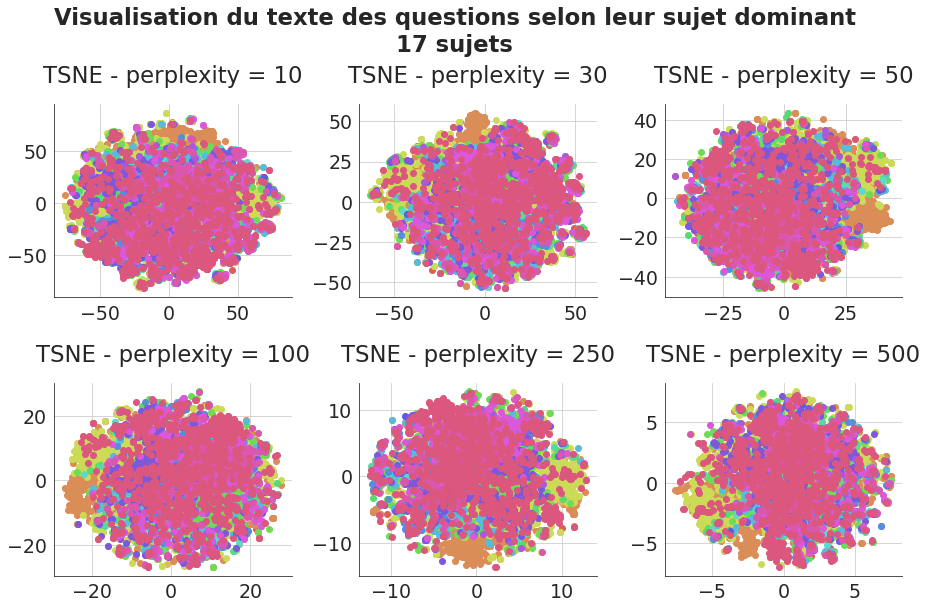

In [ ]:
graph_title = "Visualisation du texte des questions selon leur sujet dominant\n17 sujets"
graph = sfg.MyGraph(graph_title, y_title=0.95, nblin=2, nbcol=3,
                    color_palette="hls", ncolors=nb_topics, figsize=(13,9))
for i in range(len(list_perplexity)):
    xreduc = X_reduc[i]
    for t in range(nb_topics):
        graph.add_scatter(xreduc[X_main_topic==t].iloc[:, 0], xreduc[X_main_topic==t].iloc[:, 1],
                          uniquecolor=graph.liste_couleurs[t],
                          subtitle="TSNE - perplexity = {}".format(list_perplexity[i]),
                          multi_index=i+1)
fig, ax = graph.fig, graph.ax
save_fig("ml05_02_tsne_texte_17topics")
plt.show()

It is really difficult to define the theme of each topic found by the LDA.  
There are a lot of overlaping between the topics. This overlaping means that the number of topics is too large. But with a smaller number of topics, the results were not more interpretable.  
I look at the most representative question for each topic, in order to try to identify their main subject.

In [ ]:
for idx_topic in range(nb_topics):
    docmax = np.argmax(fact.matrix_doctopics[:, idx_topic])
    print("Topic {} : {}".format(idx_topic, X_train.iloc[docmax].body))

Topic 0 : I´m trying to use a  for my Application. First i added  to my project:  secound i add this code to my menu:  but when i start the  i get this:   03-07 17:25:39.110  16861-16861/de.treevo.app W/MenuInflater﹕ Cannot   instantiate class: android.support.v7.widget.SearchView       java.lang.reflect.InvocationTargetException               at java.lang.reflect.Constructor.newInstance(Native Method)               at android.view.MenuInflater$MenuState.newInstance(MenuInflater.java:471)               at android.view.MenuInflater$MenuState.setItem(MenuInflater.java:430)               at android.view.MenuInflater$MenuState.addItem(MenuInflater.java:451)               at android.view.MenuInflater.parseMenu(MenuInflater.java:188)               at android.view.MenuInflater.inflate(MenuInflater.java:110)               at de.treevo.app.search.onCreateOptionsMenu(search.java:260)               at android.app.Activity.onCreatePanelMenu(Activity.java:2538)               at com.android.internal

We can see that the topic modelisation doesn't get good results. It is difficult to define a precise subject for each topic.

---
<a id='4_0'></a>

## <font color=blue>4. Topic modeling with Non-negative Matrix Factorization (NMF)</font>

### 4.1. Impact of vectorization options on NMF coherence score

In [ ]:
bow.set_params(**{"min_df": my_mindf, "ngram_range": (1, 1)})

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.01,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='(?!\\d+)\\w+[\\w\\+\\#]*',
                tokenizer=None, vocabulary=None)

In [ ]:
fact = TextFactorization(vectorizer=bow, model=nmf)
fact.fit(X_mini.body)
nmf_base_score = fact.coherence_score()
print(nmf_base_score)

0.4105663146733171


In [ ]:
fact = TextFactorization(vectorizer=tfidf, model=nmf)
fact.fit(X_mini.body)
nmf_tfidf_score = fact.coherence_score()
print(nmf_tfidf_score)

0.4373899695033107


In [ ]:
bow.set_params(**{"ngram_range": (1, 2)})
fact = TextFactorization(vectorizer=bow, model=nmf)
fact.fit(X_mini.body)
nmf_bigrams_score = fact.coherence_score()
print(nmf_bigrams_score)

0.5661746939806578


In [ ]:
bow.set_params(**{"ngram_range": (1, 3)})
fact = TextFactorization(vectorizer=bow, model=nmf)
fact.fit(X_mini.body)
nmf_trigrams_score = fact.coherence_score()
print(nmf_trigrams_score)

0.7045753618169492


In [ ]:
bow.set_params(**{"ngram_range": (1, 1)})
fact = TextFactorization(vectorizer=bow, model=nmf)
fact.fit(X_mini.title)
nmf_title_score = fact.coherence_score()
print(nmf_title_score)

0.33131947638916204


In [ ]:
fact = TextFactorization(vectorizer=bow, model=nmf)
fact.fit(X_mini.both)
nmf_both_score = fact.coherence_score()
print(nmf_both_score)

0.41355535382513253


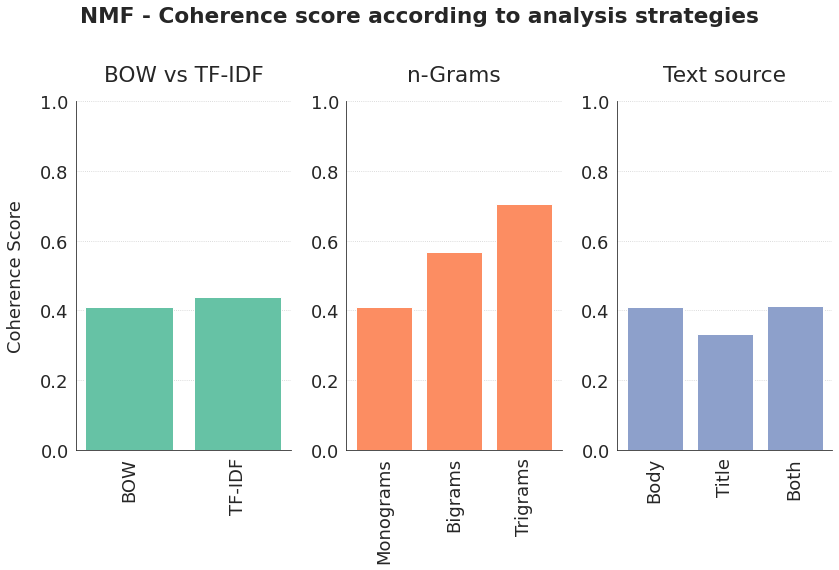

In [ ]:
graph = sfg.MyGraph("NMF - Coherence score according to analysis strategies",
                    y_title=1.0, nblin=1, nbcol=3)
graph.add_barv(["BOW", "TF-IDF"],
               [nmf_base_score, nmf_tfidf_score],
               subtitle="BOW vs TF-IDF", multi_index=1)
graph.add_barv(["Monograms", "Bigrams", "Trigrams"],
               [nmf_base_score, nmf_bigrams_score, nmf_trigrams_score],
               subtitle="n-Grams", color=graph.liste_couleurs[1],
               multi_index=2)
graph.add_barv(["Body", "Title", "Both"],
               [nmf_base_score, nmf_title_score, nmf_both_score],
               subtitle="Text source", color=graph.liste_couleurs[2],
               multi_index=3)
graph.set_axe_y(label="Coherence Score", tick_min=0, tick_max=1,
                multi_index=1)
graph.set_axe_y(tick_min=0, tick_max=1, multi_index=2)
graph.set_axe_y(tick_min=0, tick_max=1, multi_index=3)
graph.set_axe_x(rotation=90, multi_index=1)
graph.set_axe_x(rotation=90, multi_index=2)
graph.set_axe_x(rotation=90, multi_index=3)
fig, ax = graph.fig, graph.ax
save_fig("ml05_02_nmf_vectorization")
plt.show()

I use a TF-IDF matrix based on the aggregation of body and title texts as input, with bigrams and trigrams added to the monograms.

<a id="4_2"></a>

### 4.2. Impact of the number of topics and the min-df parameter on the coherence score

In [ ]:
nmf_coherence_scores = pd.DataFrame(columns=["n_components",
                                         "min_df",
                                         "coherence_score"])

In [ ]:
tfidf.set_params(**{"ngram_range": (1, 3)})
idx = 0
for ncompo in range(2, 21):
    nmf.set_params(**{"n_components": ncompo})
    for mindf in [0.05, 0.025, 0.01, 0.005]:
        tfidf.set_params(**{"min_df": mindf})
        fact = TextFactorization(vectorizer=tfidf, model=nmf)
        fact.fit(X_mini.both)
        cs = fact.coherence_score()
        nmf_coherence_scores.loc[idx] = [ncompo, mindf, cs]
        idx += 1

In [ ]:
nmf_coherence_scores

n_components  min_df  coherence_score
0            2.0   0.050         0.773292
1            2.0   0.025         0.773433
2            2.0   0.010         0.771956
3            2.0   0.005         0.773721
4            3.0   0.050         0.759533
..           ...     ...              ...
71          19.0   0.005         0.662677
72          20.0   0.050         0.712451
73          20.0   0.025         0.707970
74          20.0   0.010         0.704542
75          20.0   0.005         0.662855

[76 rows x 3 columns]

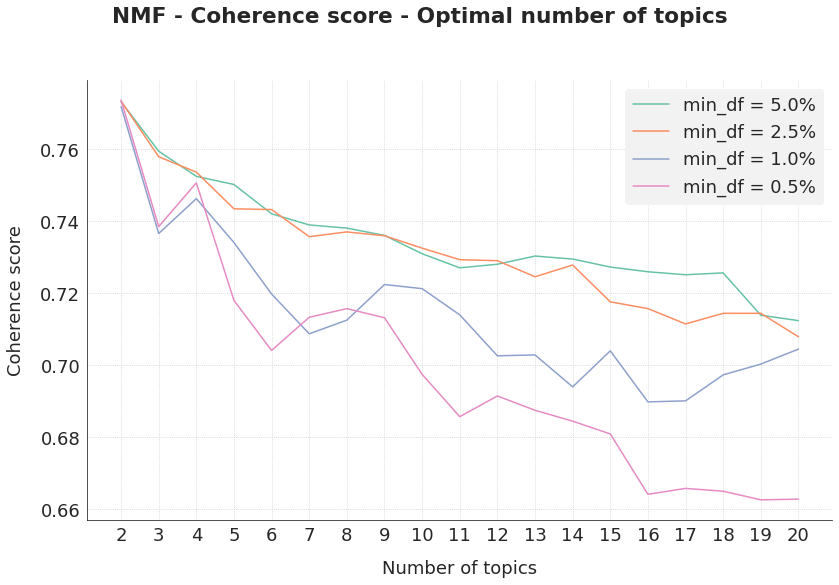

In [ ]:
graph = sfg.MyGraph("NMF - Coherence score - Optimal number of topics")
for mindf in nmf_coherence_scores.min_df.unique():
    graphdata = nmf_coherence_scores[nmf_coherence_scores.min_df == mindf]
    graph.add_plot(graphdata.n_components,
                   graphdata.coherence_score,
                   label="min_df = {:.1%}".format(mindf),
                   with_grid="both", grid_style=":", legend=True)
graph.set_axe_x(label="Number of topics", tick_labels_format=":.0f",
                tick_min=2, tick_max=20, tick_step=1)
graph.set_axe_y(label="Coherence score")
fig, ax = graph.fig, graph.ax
save_fig("ml05_02_nmf_nb_topics")
plt.show()

The optimal number of topics with NMF is 2. This is not adapted to our problem.

<a id="4_3"></a>

### 4.3. Alternative try : using Universal Sentence Encoder together with NMF

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
embeddings = embed(X_mini.both)

In [ ]:
embeddings[embeddings < 0]

<tf.Tensor: shape=(3433335,), dtype=float32, numpy=
array([-0.03440425, -0.0778978 , -0.01672957, ..., -0.01044338,
       -0.03737742, -0.04043469], dtype=float32)>

There are negative values in the embedded data with Universal Sentence Encoder. So, we can't use this embedding with NMF.

---
<a id='5_0'></a>

## <font color=blue>5. Annex for part 3 of the project : Calculation of coherence score of the best semi-supervised model</font>

The best semi-supervised model is based on a BOW vectorizer on single words, with a min df of 0.3% and a max df set to 96.8%. The factorization is done with a Non-negative Matrix Factorization with 90 components.  
I want to know the coherence score of this factorization.

In [ ]:
vectorizer = CountVectorizer(token_pattern=my_regex,
                             stop_words=full_stop_words,
                             min_df=0.003, max_df=0.968, ngram_range=(1,1))
factorizer = NMF(n_components=90, random_state=42)

In [ ]:
fact = TextFactorization(vectorizer=vectorizer, model=factorizer)
fact.fit(X_mini.title)
coherence_score = fact.coherence_score()
print("Coherence score of the best semi-supervised model = {:.2%}".format(coherence_score))

Coherence score of the best semi-supervised model = 50.56%


In [ ]:
fact = TextFactorization(vectorizer=vectorizer, model=factorizer)
fact.fit(X_train.title)
coherence_score = fact.coherence_score()
print("Coherence score of the best semi-supervised model = {:.2%}".format(coherence_score))

Coherence score of the best semi-supervised model = 29.36%
